# Análise de Usuários através de Keystrokes

Nesse trabalho, busco explorar o quanto o modo como um usuário digita diz sobre ele. É possível dicerní-lo de outros apenas por seu padrão de digitação? Conseguimos agrupar usuários que digitam de forma parecida? O que mais é possível extrair de dados de telcas?

## Motivação

Qual a utilidade de ser se estudar padrões de digitação de um usuário?

Assumindo que cada usuário tem um padrão de digitação único, ou pelo menos razoavelmente único, é possível pensar em uma tarefa de identificação. Sites como o Coursera utilizam esses dados justamente para julgar se um aluno realmente está fazendo os deveres do curso. Logo quando um usuário se cadastra, ele deve digitar um parágrafo para que um perfil associado seja criado. Esse perfil é então comparado posteriormente aos textos (códigos ou respostas discursivas) escritos pelo aluno. Por ser utilizado por tanto tempo na plataforma, podemos suspeitar que esse tipo de dado é um bom indicativo de unicidade.

Outra aplicação possível é identificação de usuários fazendo login. Se um sistema for capaz de identificar o usuário pelo modo como digita, uma camada a mais de segurança pode ser criada. Afinal, não basta saber a senha da conta, é necessário digitar como o dono original digita. Dessa forma, fraudes por senhas vazadas, bancos de dados comprometidos, ou até mesmo senhas anotadas em _post-its_ no monitor podem ser evitadas.

Para o caso de uso da senha é interessante notar um detalhe que é o não envio da senha em _plain text_ ao servidor verificador. É extremamente comum - se crucial para uma base mínima de segurança - que a senha de um usuário não trafegue a rede em _plain text_. Isso porque é muito fácil um malfeitor capturar dados transientes em uma rede (principalmente pública). Dessa forma, se a senha não tiver nenhum mecanismo de proteção, a conta do usuário estará comprometida.

O que normalmente ocorre é o envio de um _hash_ da senha. O _hash_ nada mais é do que uma função que leva uma entrada a uma saída de forma simples, mas garante que a inversão (sabendo uma saída, encontrar a entrada correspondente) é uma tarefa árdua. Utilizando esse método, sites que permitem fazer login não precisam guardar as senhas de seus usuários, basta guardar os hashes das senhas. Afinal, como cada senha sempre produz o mesmo hash, é possível comparar hashes para saber se a senha está correta. Aplicando essa metodologia, mesmo que ocorra um vazamento de senhas ou uma senha seja fisgada em trânsito, o segredo está seguro. Apenas o hash foi comprometido e como dito acima, hashes são difíceis de reverter.

O que isso implica na utilização de dados de digitação para verificação do usuário? Imediatamente, significa que não se pode utilizar as teclas nem os tempos de digitação entre elas para tirar tais conclusões. Afinal, se isso fosse utilizado, todo o propósito de não enviar a senha em _plain text_ estará perdido. Soluções mais criativas terão que ser utilizadas, como veremos a frente.

## Dataset

Para começar a exploração desse tópico, escolhi um dataset famoso de dados de _keystrokes_. O dataset é conhecido como _CMU Keystroke Dynamics – Benchmark Data Set_.

### Contrução do dataset

Esse dataset foi montado com dados de 51 pessoas diferentes digitando a senha `.tie5Roanl` repetidas vezes. Ao todo foram 400 repetições por pessoa espaçadas em sessões distintas. Em cada sessão a pessoa digitava a senha 50 vezes, implicando num total de 8 sessões que foram feitas com pelo menos um dia de folga entre elas para capturar a variação de padrões de digitação ao longo de dias.

### Dados coletados

Resta, agora, sabermos que métricas foram efetivamente coletadas e armazenadas nesse dataset. Cada sessão de coleta captura três tipos de dados: `Hold`, `Down-Down`, `Up-Down`.

![Métricas coletadas](data_explanation.jpg)

- Hold: Mede o tempo que uma tecla foi pressionada (desde o momento que foi abaixada até quando é solta).
- Down-Down: Mede o tempo entre uma tecla ser abaixada e a próxima ser abaixada.
- Up-Down: Mede o tempo entre uma tecla ser solta e a próxima abaixada.

Dessa forma, como o texto digitado foi `.tie5Roanl`, cada entrada do dataset será composta dos seguintes atributos:

```
subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i, ... , H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
```

O primeiro parâmetro indica qual participante digitou essa entrada do dataset. O atributo `sessionIndex` indica a qual sessão essa captura faz parte e `rep` qual a repetição dentro dessa sessão. A partir desse ponto começam as medidas de tempo. O primeiro campo, `H.period`, indica o tempo que a tecla de _ponto final_ ficou pressionada (_Hold period_). Em seguida, temos `DD.period.t` que indica o tempo entre a tecla de _ponto final_ ser pressionada para baixo e a tecla `t` ser pressionada para baixo (_Down-Down period t_). Analogamente, `UD.period.t` mostra o tempo entre soltar o _ponto final_ e pressionar a tecla `t`. As mesmas três métricas se repetem para as próximas teclas da senha. É importante notar que a tecla `Enter` foi pressionada ao final da digitação e é expressa no dataset por meio do termo _Return_.

## Análise inicial dos dados

Sabendo como o dataset foi construído, comecemos por tentar entender seus dados. Comecemos por uma redução de dimensionalidade para ser possível desenhar um plot 2D dos pontos. Com isso teremos alguma ideia de como os dados se comportam.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from copy import deepcopy

Comecemos por ler os dados do arquivo em que estão salvos e separá-los por linhas. Aqui também jogaremos o cabeçalho fora, visto que não será utilizado nas manipulações e já temos uma descrição dos dados acima.

In [2]:
# Lendo dados do arquivo
with open("DSL-StrongPasswordData.csv") as f:
    data = np.array([line.split(",") for line in f.read().strip().split("\n")[1:]])

Agora, separemos os identificadores de usuários dos dados propriamente ditos.

In [3]:
# Formatando os dados
np.random.seed(1234)
np.random.shuffle(data)
recordings, keystrokes = data[:,:3], data[:,3:].astype(float)
print(recordings[:2], "\n", keystrokes[:2])

[['s040' '5' '44']
 ['s036' '7' '35']] 
 [[ 0.1227  0.3441  0.2214  0.1071  0.1493  0.0422  0.106   0.3349  0.2289
   0.153   0.73    0.577   0.0731  0.5698  0.4967  0.0839  0.3472  0.2633
   0.1124  0.16    0.0476  0.1765  0.2884  0.1119  0.1097  0.3012  0.1915
   0.0823  0.2655  0.1832  0.1084]
 [ 0.0377  0.5097  0.472   0.0475  0.2709  0.2234  0.0409  0.2883  0.2474
   0.0457  0.4903  0.4446  0.042   0.4409  0.3989  0.0351  0.605   0.5699
   0.0285  0.2008  0.1723  0.0525  0.3788  0.3263  0.0327  0.4781  0.4454
   0.0393  0.4406  0.4013  0.0364]]


Para termos certeza de que tudo está coerente no dataset, verifiquemos a quantidade de colunas da matriz e comparemos com o tamanho do que foi digitado.

In [4]:
password = ".tie5Roanl\n" # Lembrando que o enter é pressionado ao final da senha
print("Número de teclas na digitação da senha: {}".format(len(password)))
print("Número de colunas na matriz do dataset: {}".format(keystrokes.shape[1]))

Número de teclas na digitação da senha: 11
Número de colunas na matriz do dataset: 31


Exatamente como o esperado. Afinal, temos três medições por tecla pressionada (exceto a última) e temos 11 teclas pressionadas. Como não há teclas após o `Enter`, essa tecla só terá a métrica de `Hold` medida. Isso totalizará em exatas **31 medições**, como imaginávamos.

Verifiquemos agora o número de usuários no dataset.

In [5]:
users = sorted(list(set(recordings[:,0])))
print("Identificadores de usuários: {}".format(users))
print("Quantidade de usuários únicos: {}".format(len(users)))

Identificadores de usuários: ['s002', 's003', 's004', 's005', 's007', 's008', 's010', 's011', 's012', 's013', 's015', 's016', 's017', 's018', 's019', 's020', 's021', 's022', 's024', 's025', 's026', 's027', 's028', 's029', 's030', 's031', 's032', 's033', 's034', 's035', 's036', 's037', 's038', 's039', 's040', 's041', 's042', 's043', 's044', 's046', 's047', 's048', 's049', 's050', 's051', 's052', 's053', 's054', 's055', 's056', 's057']
Quantidade de usuários únicos: 51


Temos 51 usuários únicos, novamente como esperado.

## Redução de Dimensionalidade

Para ganharmos uma intuição sobre comportamento de cada usuário, podemos tentar desenhar os pontos do dataset em um gráfico. Entretanto, como os dados são de dimensão 31, é preciso aplicar algum tipo de redução de dimensionalidade para que esse gráfico se torne possível.

### SVD

Uma técnica que permite essa redução é o SVD (Singular Value Decomposition). Com o SVD conseguimos encontrar uma base boa para representar nossos dados. Não só isso, como também é possível verificar a importância de cada dimensão para a representação dos dados. Isso será importante para analisarmos a quantidade de informação que está sendo perdida com a simplificação dos dados.

Antes de fazermos qualquer manipulação com os dados, entretanto, é interessante normalizá-los.

In [6]:
mean = np.mean(keystrokes, axis=0)
std = np.std(keystrokes, axis=0)

norm_keystrokes = (keystrokes - mean) / std

Uma vez com os dados normalizados, podemos prosseguir com a redução de dimensionalidade. A técnica de SVD decompõe uma matriz em três, $U$, $\Sigma$ e $V^T$. Juntas elas tais matrizes formam a original de acordo com a relação $U \Sigma V^T = M$, onde $M$ é a matriz original.

Para compreendermos melhor o que o SVD faz com uma matriz, primeiro precisamos entender o que a matriz original significa. No caso desse dataset, cada linha da matriz $M$ representa um usuário e cada coluna uma métrica de digitação. Dessa forma, podemos enxergar a matriz $M$ como a matriz que nos leva de usuário para digitação. É importante manter essa relação em mente, pois se nos propusermos a fazer uma decomposição dessa matriz, é importante que essa relação se mantenha.

$$
    \text{Usuários} \Bigg \{ 
    \overbrace{
    \begin{bmatrix}
          &   &  &  \\
          &   &  &  \\
          &   &  &  
    \end{bmatrix}
    }^\text{Digitação}
$$

Como dito anteriormente, o SVD "_procura uma base boa_" para a representação dos dados. O que exatamente significa essa "_base boa_"?

Por _base boa_, o algoritmo entende ser a base nas quais as dimensões capturam o máximo de informação possível. Em termos estatísticos, são as dimensões com maior variância dos dados.

<b style="color:red;">[imagem mostrando pontos variando muito sobre um vetor e pouco sobre outros. Ao lado, imagem mostrando o eixo que melhor representa os dados. 2D -> 1D]</b>

Dessa forma, se pegarmos apenas as dimensões com maior informação, seremos capazes de manter os dados quase íntegros e ao mesmo tempo reduzir sua dimensionalidade. Como no exemplo acima, vemos que os pontos variam muito na direção do vetor destacado. Significa que se projetarmos os pontos nesse vetor, poderemos representá-los - quase que fielmente - com apenas um número: a magnitude do deslocamento a partir da origem nessa direção. Dessa forma, reduzimos com sucesso dados originalmente em 2D para dados em 1D.

Agora, analisemos possíveis interpretações das matrizes resultantes do SVD no dataset de padrões de digitação. O algoritmo leva os pontos do dataset da base original para uma base ideal. Isso pode ser visto analisando o papel de cada matriz resultante.

In [7]:
U, Sigma, Vt = np.linalg.svd(norm_keystrokes)

Começando por $U$, podemos interpretar seu papel como sendo a matriz que leva os usuários a esse espaço ideal encontrado pelo SVD. Em seguida, temos $\Sigma$. Essa é a matriz responsável por escalar os pontos no espaço ideal de acordo com a _importância_ de cada dimensão nesse espaço. Finalmente temos $V^T$ que pode ser vista como a matriz que traz os dados de volta do espaço ideal para o espaço de digitação.

Vendo a decomposição dessa forma, acabamos com a mesma interpretação da matriz original - uma matriz que leva de usuários para métricas de digitação. O grande ganho é que o SVD nos permite enxergar os dados em uma dimensão ideal intermediária. Nela, podemos fazer manipulações nos dados que nos permite, por exemplo, reduzir a dimensionalidade preservando o máximo de informação possível.

A "importância" de cada dimensão está atrelada à magnitude dos valores singulares da matriz $\Sigma$. Vendo a relação desses valores podemos tirar conclusões sobre a dimensão real dos dados.

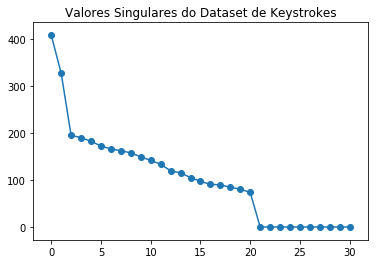

In [8]:
plt.plot(Sigma)
plt.scatter(np.arange(31), Sigma)
plt.title("Valores Singulares do Dataset de Keystrokes")
plt.show()

Olhando para esse gráfico, vemos de imediado que a partir da dimensão ideal 20 as outras dimensões praticamente não contribuem para a informação real dos dados. Em termos um pouco mais formais, praticamente não há variação dos dados ao longo das dimensões superiores à vigésima.

Mais do que isso, é possível notar que as duas primeiras dimensões contribuem com a maior parte da informação dos dados. A partir da terceira, as dimensões ficam progressivamente menos relevantes de forma gradual.

Isso tudo indica que nosso gráfico em 2D dos pontos conterá uma boa parte da informação do dataset original. Portanto será uma boa visualização dos dados.

Para fazermos esse gráfico em 2D dos pontos, basta lembrarmos da interpretação das matrizes resultantes da decompoisção. Queremos levar nossos pontos ao espaço ideal e ignorar todas as dimensões exceto as duas primeiras.

O primeiro passo pode ser facilmente feito apenas com a matriz $U$ - afinal ela é a responsável por levar os pontos para o espaço ideal. Em seguida, basta zerarmos os valores singulares indesejáveis da matriz $\Sigma$ que zeraremos as coordenadas indesejadas dos pontos.

In [9]:
reduced_sigma = np.zeros((U.shape[1], Sigma.shape[0]))
reduced_sigma[0,0] = Sigma[0]
reduced_sigma[1,1] = Sigma[1]
print("Matriz Sigma Reduzida:\n",reduced_sigma, end="\n\n")
print("Dimensões de Sigma Reduzida:",reduced_sigma.shape)

Matriz Sigma Reduzida:
 [[ 407.97342532    0.            0.         ...,    0.            0.            0.        ]
 [   0.          326.96957765    0.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.            0.            0.        ]
 ..., 
 [   0.            0.            0.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.            0.            0.        ]
 [   0.            0.            0.         ...,    0.            0.            0.        ]]

Dimensões de Sigma Reduzida: (20400, 31)


Como queremos ficar no espaço ideal, basta não incluirmos a matriz $V^T$ - cuja função é trazer os pontos de volta ao espaço original.

In [10]:
reduced_keystrokes = U @ reduced_sigma
print(reduced_keystrokes)
print(reduced_keystrokes.shape)

[[ 0.79661649 -3.14352362  0.         ...,  0.          0.          0.        ]
 [ 7.33690199  2.98459802  0.         ...,  0.          0.          0.        ]
 [-0.41674256  3.11857179  0.         ...,  0.          0.          0.        ]
 ..., 
 [-1.29789951 -1.33182584  0.         ...,  0.          0.          0.        ]
 [ 0.54700926 -1.83758573  0.         ...,  0.          0.          0.        ]
 [ 1.03072995 -1.17526715  0.         ...,  0.          0.          0.        ]]
(20400, 31)


Como podemos ver, zeramos as coordenadas menos relevantes com sucesso. Basta então usarmos as que sobraram para desenhar o gráfico.

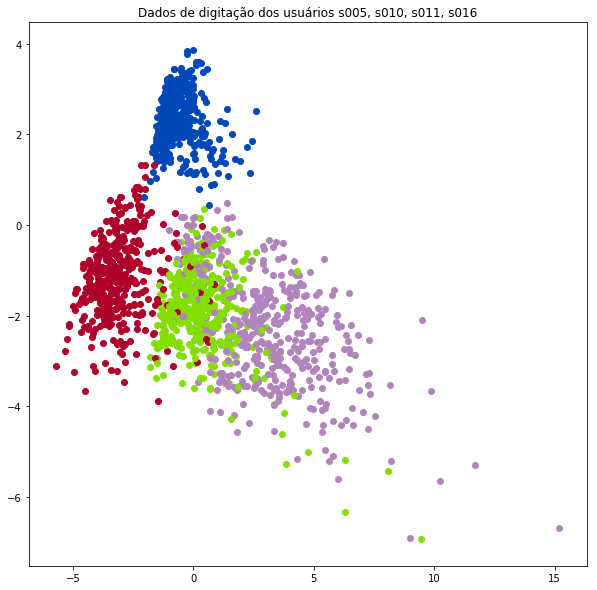

In [11]:
colors = {"s002": "#E32636", "s003": "#B0BF1A", "s004": "#7CB9E8", "s005": "#84DE02", "s007": "#EFDECD", "s008": "#00308F", "s010": "#0048BA", "s011": "#AF002A", "s012": "#C9FFE5", "s013": "#72A0C1", "s015": "#C46210", "s016": "#B284BE", "s017": "#E52B50", "s018": "#9F2B68", "s019": "#F19CBB", "s020": "#AB274F", "s021": "#D3212D", "s022": "#3B7A57", "s024": "#FFBF00", "s025": "#FF7E00", "s026": "#3B3B6D", "s027": "#391802", "s028": "#804040", "s029": "#D3AF37", "s030": "#34B334", "s031": "#FF8B00", "s032": "#FF9899", "s033": "#431C53", "s034": "#B32134", "s035": "#FF033E", "s036": "#CFCFCF", "s037": "#551B8C", "s038": "#F2B400", "s039": "#9966CC", "s040": "#A4C639", "s041": "#F2F3F4", "s042": "#CD9575", "s043": "#665D1E", "s044": "#915C83", "s046": "#841B2D", "s047": "#FAEBD7", "s048": "#008000", "s049": "#66B447", "s050": "#8DB600", "s051": "#FBCEB1", "s052": "#00FFFF", "s053": "#7FFFD4", "s054": "#D0FF14", "s055": "#C0C0C0", "s056": "#4B5320", "s057": "#3B444B"}
reduced_keystrokes_ = reduced_keystrokes[:,:2]

vis_users = ["s005", "s010", "s011", "s016"]
plt.figure(figsize=(10,10))
for i, point in enumerate(reduced_keystrokes_):
    #Para facilitar a visualização, faremos o plot de apenas quatro usuários
    if recordings[i][0] in vis_users:
        plt.scatter(point[0], point[1], c=colors[recordings[i][0]])
plt.title("Dados de digitação dos usuários {}".format(", ".join(vis_users)))
plt.show()

Observando o gráfico, vemos que a redução de dimensionalidade realmente funcionou. Usando a técnica de SVD conseguimos visualizar as diferenças nos padrões de digitação das pessoas utilizadas na criação do dataset.

Podemos ver que usando apenas duas dimensões não é sempre óbiva a distinção de cada par de usuários. No exemplo do gráfico acima, vemos uma clara separação entre os usuários azul, vermelho escuro e verde - com pontos concentrados em regiões diferentes do espaço. Já o usuário roxo, se mistura consideravelmente com o verde. Isso pode ser reflexo de uma possível proximidade do modo como ambos digitam, ou simplesmente uma limitação da visualização em 2D do dataset.

Podemos, por fim, tentar estimar a grosso modo quanta informação retemos ao simplificar os dados para 2D. Para isso, podemos usar os valores singulares obtidos em $\Sigma$. A ideia é simplesmente verificar a proporção das dimensões retidas em relação ao total.

In [12]:
retained_info = (Sigma[0] + Sigma[1]) / np.sum(Sigma)
print("Estimativa de informação retida: {}%".format(100*retained_info))

Estimativa de informação retida: 22.684216838113194%


Diminuindo o espaço dos pontos do dataset da forma que fizemos, somos capazes de reter em torno de 22% da informação do dado original. Essa estimativa não pode ser levada tão literalmente, mas ajuda a entender o que estamos preservando.

Mesmo com apenas um quinto da informação original, ainda somos capazes de visualmente discernir alguns usuários. Isso realmente é um indicativo motivador para a próxima tarefa: classificação.

### Autoencoder

Vimos uma forma de redução de dimensionalidade, o SVD. Entretanto, essa decomposição não é a única forma de se reduzir as dimensões de dados. Existe outro método muito popular conhecido como _Autoencoder_.

A técnica de _Autoencoder_ foi desenvolvida com a popularização de redes neurais no cenário acadêmico. A proposta consiste de uma ideia muito simples. Criamos uma rede neural dividida em duas partes: um _encoder_ e um _decoder_. O encoder é responsável por pegar o dado no espaço original e levá-lo para um espaço latente (_embedding space_). O decoder faz justamente o oposto, ou seja, recebe como entrada um vetor no espaço latente e o converte de volta ao espaço original.

<center>
```
embedding = encoder(dado original)
dado reconstruido = decoder(embedding)
```
</center>

A ideia é treinar a rede para encontrar o melhor espaço latente possível para representar os dados. Em termos mais concretos, estamos tentando minimizar a diferença entre o dado reconstruido e o dado original controlando as funções de _encoding_ e _decoding_.

$$
    decoder, encoder = \arg \min_{d,e}{\lVert X - d(e(X)) \rVert ^2}
$$

O espaço de embedding pode ser arbitrariamente escolhido, mas como nosso objetivo é realizar uma redução de dimensionalidade, é interessante escolhermos um espaço com dimensão menor. Mais especificamente, queremos um espaço em 2D para fazermos um gráfico representativo do dataset.

Para isso, construimos uma rede neural que afunila e depois expande os dados. A camada inicial da rede é da dimensão original do dado. A partir da primeira, as camadas ficam progressivamente menores, forçando uma representação mais densa de nossos dados. Quando chegamos na dimensão desejada, começamos o processo de reconstrução do dado. A partir desse ponto, as camadas ficam progressivamente maiores até atingirem o tamanho original.

![Estrutura de um Autoencoder](Autoencoder_structure.png)

Construiremos uma rede com a mesma quantidade de camadas que a imagem acima mostra. Aproveitando que já calculamos os valores singulares previamente usando o SVD, vemos que realmente só precisamos de 20 dimensões para representar fielmente nossos dados. Dessa forma, podemos supor que é uma boa escolha fazer as camadas intermediárias entre o dado original e a representação 2D ter ser de tamanho 20.


<center>
```
dado (31D) -> dado (20D) -> dado (2D) -> dado (20D) -> dado (31D)
```
</center>

O fato de termos camadas intermediárias entre a representação 2D e a original ajuda a dar mais flexibilidade para manipulação da rede.

In [13]:
with tf.device("/device:CPU:0"):
    x = tf.placeholder(tf.float32, shape=[None, 31])

    encoder_W1 = tf.get_variable("e_W1", shape=[31, 20], initializer=tf.contrib.layers.xavier_initializer())
    encoder_b1 = tf.Variable(tf.zeros([20]), name="e_b1")

    embedding_20D = tf.nn.relu(tf.matmul(x, encoder_W1) + encoder_b1)

    encoder_W2 = tf.get_variable("e_W2", shape=[20, 2], initializer=tf.contrib.layers.xavier_initializer())
    encoder_b2 = tf.Variable(tf.zeros([2]), name="e_b2")

    embedding_2D = tf.matmul(embedding_20D, encoder_W2) + encoder_b2
    embedding_2D_activated = tf.nn.sigmoid(embedding_2D)

    decoder_W1 = tf.get_variable("d_W1", shape=[2, 20], initializer=tf.contrib.layers.xavier_initializer())
    decoder_b1 = tf.Variable(tf.zeros([20]), name="d_b1")

    reconstruction_20D = tf.nn.relu(tf.matmul(embedding_2D_activated, decoder_W1) + decoder_b1)

    decoder_W2 = tf.get_variable("d_W2", shape=[20, 31], initializer=tf.contrib.layers.xavier_initializer())
    decoder_b2 = tf.Variable(tf.zeros([31]), name="d_b2")

    reconstruction_31D = tf.nn.relu(tf.matmul(reconstruction_20D, decoder_W2) + decoder_b2)

    loss = tf.reduce_mean(tf.pow(x - reconstruction_31D, 2))

    train_step = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(loss)

In [14]:
split_data_idx = 20000
train_data = norm_keystrokes[:split_data_idx]
test_data = norm_keystrokes[split_data_idx:]

In [15]:
def next_batch(size, i):
    k = train_data[i*size:(i+1)*size]
    return k

In [16]:
saver = tf.train.Saver()

In [17]:
losses = []
min_loss = float("inf")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(100):
        for i in range(200):
            batch = next_batch(100, i)
    #         print(batch[0].shape, batch[1].shape)
#             train_step.run(feed_dict={x: batch})
            _, current_loss = sess.run([train_step, loss], feed_dict={x:batch})
            losses.append(current_loss)
            print("Ep {}: Batch #{} - Loss: {}".format(epoch, i, losses[-1]))
            if losses[-1] < min_loss:
                min_loss = losses[-1]
                save_path = saver.save(sess, "./weights_autoencoder_low_LR/model_e{}b{}_{}.ckpt".format(epoch, i, time.time()))
                print("Model saved in file: %s" % save_path)

Ep 0: Batch #0 - Loss: 0.8616877198219299
Model saved in file: ./weights_autoencoder_low_LR/model_e0b0_1516651268.3718064.ckpt
Ep 0: Batch #1 - Loss: 0.9478267431259155
Ep 0: Batch #2 - Loss: 1.0629867315292358
Ep 0: Batch #3 - Loss: 0.9341558814048767
Ep 0: Batch #4 - Loss: 0.8574299216270447
Model saved in file: ./weights_autoencoder_low_LR/model_e0b4_1516651268.3963735.ckpt
Ep 0: Batch #5 - Loss: 0.7206717729568481
Model saved in file: ./weights_autoencoder_low_LR/model_e0b5_1516651268.4175773.ckpt
Ep 0: Batch #6 - Loss: 0.9528446197509766
Ep 0: Batch #7 - Loss: 0.7587512731552124
Ep 0: Batch #8 - Loss: 0.7932882308959961
Ep 0: Batch #9 - Loss: 1.492522954940796
Ep 0: Batch #10 - Loss: 1.0801488161087036
Ep 0: Batch #11 - Loss: 0.7347844243049622
Ep 0: Batch #12 - Loss: 1.6323261260986328
Ep 0: Batch #13 - Loss: 0.6900389194488525
Model saved in file: ./weights_autoencoder_low_LR/model_e0b13_1516651268.4417918.ckpt
Ep 0: Batch #14 - Loss: 0.7821448445320129
Ep 0: Batch #15 - Loss: 1

Ep 1: Batch #163 - Loss: 0.9854888916015625
Ep 1: Batch #164 - Loss: 0.8406349420547485
Ep 1: Batch #165 - Loss: 1.5592222213745117
Ep 1: Batch #166 - Loss: 0.7415074706077576
Ep 1: Batch #167 - Loss: 1.1531727313995361
Ep 1: Batch #168 - Loss: 0.9256900548934937
Ep 1: Batch #169 - Loss: 0.8617210984230042
Ep 1: Batch #170 - Loss: 0.8638564944267273
Ep 1: Batch #171 - Loss: 0.8499883413314819
Ep 1: Batch #172 - Loss: 0.6803367733955383
Ep 1: Batch #173 - Loss: 1.2827649116516113
Ep 1: Batch #174 - Loss: 0.6320725679397583
Ep 1: Batch #175 - Loss: 0.8325157761573792
Ep 1: Batch #176 - Loss: 1.2196907997131348
Ep 1: Batch #177 - Loss: 0.9093984961509705
Ep 1: Batch #178 - Loss: 0.8276426196098328
Ep 1: Batch #179 - Loss: 1.013136625289917
Ep 1: Batch #180 - Loss: 0.9317285418510437
Ep 1: Batch #181 - Loss: 1.0726593732833862
Ep 1: Batch #182 - Loss: 0.8210064172744751
Ep 1: Batch #183 - Loss: 0.8252896070480347
Ep 1: Batch #184 - Loss: 1.127348780632019
Ep 1: Batch #185 - Loss: 0.8123639

Ep 3: Batch #73 - Loss: 0.9732322096824646
Ep 3: Batch #74 - Loss: 0.7962724566459656
Ep 3: Batch #75 - Loss: 0.819796085357666
Ep 3: Batch #76 - Loss: 1.15058434009552
Ep 3: Batch #77 - Loss: 0.7934693098068237
Ep 3: Batch #78 - Loss: 1.2388843297958374
Ep 3: Batch #79 - Loss: 0.681832492351532
Ep 3: Batch #80 - Loss: 0.9299426674842834
Ep 3: Batch #81 - Loss: 1.7374831438064575
Ep 3: Batch #82 - Loss: 0.9367634654045105
Ep 3: Batch #83 - Loss: 1.79010808467865
Ep 3: Batch #84 - Loss: 0.7719136476516724
Ep 3: Batch #85 - Loss: 1.0339300632476807
Ep 3: Batch #86 - Loss: 0.7702063322067261
Ep 3: Batch #87 - Loss: 0.7717743515968323
Ep 3: Batch #88 - Loss: 0.8662821054458618
Ep 3: Batch #89 - Loss: 0.9269343018531799
Ep 3: Batch #90 - Loss: 1.2398971319198608
Ep 3: Batch #91 - Loss: 0.8675117492675781
Ep 3: Batch #92 - Loss: 1.101591944694519
Ep 3: Batch #93 - Loss: 1.1128926277160645
Ep 3: Batch #94 - Loss: 1.1202465295791626
Ep 3: Batch #95 - Loss: 0.988666296005249
Ep 3: Batch #96 - L

Ep 4: Batch #150 - Loss: 0.9332417249679565
Ep 4: Batch #151 - Loss: 0.7688819766044617
Ep 4: Batch #152 - Loss: 0.7863974571228027
Ep 4: Batch #153 - Loss: 1.1766465902328491
Ep 4: Batch #154 - Loss: 0.8104060888290405
Ep 4: Batch #155 - Loss: 0.8988765478134155
Ep 4: Batch #156 - Loss: 1.0817006826400757
Ep 4: Batch #157 - Loss: 0.8137942552566528
Ep 4: Batch #158 - Loss: 0.8563665747642517
Ep 4: Batch #159 - Loss: 0.8671756982803345
Ep 4: Batch #160 - Loss: 0.9540054798126221
Ep 4: Batch #161 - Loss: 0.8733439445495605
Ep 4: Batch #162 - Loss: 0.9945790767669678
Ep 4: Batch #163 - Loss: 0.9811715483665466
Ep 4: Batch #164 - Loss: 0.8367627859115601
Ep 4: Batch #165 - Loss: 1.5551425218582153
Ep 4: Batch #166 - Loss: 0.7376711964607239
Ep 4: Batch #167 - Loss: 1.1486138105392456
Ep 4: Batch #168 - Loss: 0.9218005537986755
Ep 4: Batch #169 - Loss: 0.8574979305267334
Ep 4: Batch #170 - Loss: 0.8594989776611328
Ep 4: Batch #171 - Loss: 0.8446580171585083
Ep 4: Batch #172 - Loss: 0.67664

Ep 6: Batch #62 - Loss: 0.77871173620224
Ep 6: Batch #63 - Loss: 1.0748798847198486
Ep 6: Batch #64 - Loss: 9.481644630432129
Ep 6: Batch #65 - Loss: 0.6532191634178162
Ep 6: Batch #66 - Loss: 0.8630218505859375
Ep 6: Batch #67 - Loss: 0.9676937460899353
Ep 6: Batch #68 - Loss: 0.9681410789489746
Ep 6: Batch #69 - Loss: 0.8003733158111572
Ep 6: Batch #70 - Loss: 0.8457902073860168
Ep 6: Batch #71 - Loss: 0.7280309796333313
Ep 6: Batch #72 - Loss: 0.9117786288261414
Ep 6: Batch #73 - Loss: 0.96917724609375
Ep 6: Batch #74 - Loss: 0.7923107743263245
Ep 6: Batch #75 - Loss: 0.8157632350921631
Ep 6: Batch #76 - Loss: 1.1464059352874756
Ep 6: Batch #77 - Loss: 0.7878273129463196
Ep 6: Batch #78 - Loss: 1.2329517602920532
Ep 6: Batch #79 - Loss: 0.6772263050079346
Ep 6: Batch #80 - Loss: 0.9244162440299988
Ep 6: Batch #81 - Loss: 1.7335538864135742
Ep 6: Batch #82 - Loss: 0.9309332370758057
Ep 6: Batch #83 - Loss: 1.7858887910842896
Ep 6: Batch #84 - Loss: 0.7677822709083557
Ep 6: Batch #85 

Ep 7: Batch #137 - Loss: 1.0263817310333252
Ep 7: Batch #138 - Loss: 1.1274702548980713
Ep 7: Batch #139 - Loss: 0.9623450040817261
Ep 7: Batch #140 - Loss: 1.107053279876709
Ep 7: Batch #141 - Loss: 1.4169282913208008
Ep 7: Batch #142 - Loss: 0.8418216109275818
Ep 7: Batch #143 - Loss: 1.0366852283477783
Ep 7: Batch #144 - Loss: 0.7741469144821167
Ep 7: Batch #145 - Loss: 0.7227322459220886
Ep 7: Batch #146 - Loss: 0.9318249225616455
Ep 7: Batch #147 - Loss: 0.9258477091789246
Ep 7: Batch #148 - Loss: 1.038669228553772
Ep 7: Batch #149 - Loss: 0.9155179858207703
Ep 7: Batch #150 - Loss: 0.9295008778572083
Ep 7: Batch #151 - Loss: 0.7652021050453186
Ep 7: Batch #152 - Loss: 0.7821701765060425
Ep 7: Batch #153 - Loss: 1.1706026792526245
Ep 7: Batch #154 - Loss: 0.8068637251853943
Ep 7: Batch #155 - Loss: 0.8935282826423645
Ep 7: Batch #156 - Loss: 1.0773229598999023
Ep 7: Batch #157 - Loss: 0.8095154762268066
Ep 7: Batch #158 - Loss: 0.8510274887084961
Ep 7: Batch #159 - Loss: 0.8624410

Ep 9: Batch #40 - Loss: 0.8276094794273376
Ep 9: Batch #41 - Loss: 0.7848094701766968
Ep 9: Batch #42 - Loss: 0.7642462253570557
Ep 9: Batch #43 - Loss: 0.8364421129226685
Ep 9: Batch #44 - Loss: 0.8324617743492126
Ep 9: Batch #45 - Loss: 0.6868783235549927
Ep 9: Batch #46 - Loss: 0.8850847482681274
Ep 9: Batch #47 - Loss: 1.0276703834533691
Ep 9: Batch #48 - Loss: 1.4270679950714111
Ep 9: Batch #49 - Loss: 1.0687546730041504
Ep 9: Batch #50 - Loss: 0.7427230477333069
Ep 9: Batch #51 - Loss: 1.057366967201233
Ep 9: Batch #52 - Loss: 0.8341093063354492
Ep 9: Batch #53 - Loss: 0.8717352747917175
Ep 9: Batch #54 - Loss: 0.7473853230476379
Ep 9: Batch #55 - Loss: 0.8055645227432251
Ep 9: Batch #56 - Loss: 1.3252716064453125
Ep 9: Batch #57 - Loss: 0.9117651581764221
Ep 9: Batch #58 - Loss: 1.0635570287704468
Ep 9: Batch #59 - Loss: 0.7221449613571167
Ep 9: Batch #60 - Loss: 1.3775932788848877
Ep 9: Batch #61 - Loss: 0.6797824501991272
Ep 9: Batch #62 - Loss: 0.7742419242858887
Ep 9: Batch 

Model saved in file: ./weights_autoencoder_low_LR/model_e10b118_1516651269.9613125.ckpt
Ep 10: Batch #119 - Loss: 1.0794950723648071
Ep 10: Batch #120 - Loss: 0.8378716707229614
Ep 10: Batch #121 - Loss: 0.7317110300064087
Ep 10: Batch #122 - Loss: 0.8759748339653015
Ep 10: Batch #123 - Loss: 0.8773489594459534
Ep 10: Batch #124 - Loss: 0.7001528143882751
Ep 10: Batch #125 - Loss: 2.7818782329559326
Ep 10: Batch #126 - Loss: 1.2851812839508057
Ep 10: Batch #127 - Loss: 0.8054977059364319
Ep 10: Batch #128 - Loss: 1.1733860969543457
Ep 10: Batch #129 - Loss: 0.8922860026359558
Ep 10: Batch #130 - Loss: 0.7735013961791992
Ep 10: Batch #131 - Loss: 1.0640544891357422
Ep 10: Batch #132 - Loss: 0.878896951675415
Ep 10: Batch #133 - Loss: 0.8673275113105774
Ep 10: Batch #134 - Loss: 0.8177269697189331
Ep 10: Batch #135 - Loss: 1.0256333351135254
Ep 10: Batch #136 - Loss: 1.2463539838790894
Ep 10: Batch #137 - Loss: 1.0216598510742188
Ep 10: Batch #138 - Loss: 1.1229139566421509
Ep 10: Batch 

Ep 12: Batch #21 - Loss: 1.2610914707183838
Ep 12: Batch #22 - Loss: 0.7638697624206543
Ep 12: Batch #23 - Loss: 0.794047474861145
Ep 12: Batch #24 - Loss: 0.863759458065033
Ep 12: Batch #25 - Loss: 0.7637057304382324
Ep 12: Batch #26 - Loss: 0.7792816758155823
Ep 12: Batch #27 - Loss: 1.40898597240448
Ep 12: Batch #28 - Loss: 0.914275586605072
Ep 12: Batch #29 - Loss: 0.9485161900520325
Ep 12: Batch #30 - Loss: 1.2620693445205688
Ep 12: Batch #31 - Loss: 0.7060723304748535
Ep 12: Batch #32 - Loss: 0.7927838563919067
Ep 12: Batch #33 - Loss: 0.8490198254585266
Ep 12: Batch #34 - Loss: 0.8280386924743652
Ep 12: Batch #35 - Loss: 1.0084298849105835
Ep 12: Batch #36 - Loss: 0.7425664663314819
Ep 12: Batch #37 - Loss: 1.1888809204101562
Ep 12: Batch #38 - Loss: 0.7971931099891663
Ep 12: Batch #39 - Loss: 0.8552819490432739
Ep 12: Batch #40 - Loss: 0.8229189515113831
Ep 12: Batch #41 - Loss: 0.7814779281616211
Ep 12: Batch #42 - Loss: 0.7607942223548889
Ep 12: Batch #43 - Loss: 0.8321781158

Model saved in file: ./weights_autoencoder_low_LR/model_e13b118_1516651270.3726532.ckpt
Ep 13: Batch #119 - Loss: 1.0750221014022827
Ep 13: Batch #120 - Loss: 0.8348826766014099
Ep 13: Batch #121 - Loss: 0.727745532989502
Ep 13: Batch #122 - Loss: 0.8711462020874023
Ep 13: Batch #123 - Loss: 0.8734869360923767
Ep 13: Batch #124 - Loss: 0.6966665983200073
Ep 13: Batch #125 - Loss: 2.7762014865875244
Ep 13: Batch #126 - Loss: 1.2796887159347534
Ep 13: Batch #127 - Loss: 0.8006113171577454
Ep 13: Batch #128 - Loss: 1.1672236919403076
Ep 13: Batch #129 - Loss: 0.8878121972084045
Ep 13: Batch #130 - Loss: 0.7691851854324341
Ep 13: Batch #131 - Loss: 1.0580575466156006
Ep 13: Batch #132 - Loss: 0.8744248747825623
Ep 13: Batch #133 - Loss: 0.8629060387611389
Ep 13: Batch #134 - Loss: 0.8144217729568481
Ep 13: Batch #135 - Loss: 1.0205936431884766
Ep 13: Batch #136 - Loss: 1.2418369054794312
Ep 13: Batch #137 - Loss: 1.0168483257293701
Ep 13: Batch #138 - Loss: 1.1187225580215454
Ep 13: Batch 

Ep 15: Batch #28 - Loss: 0.9096885919570923
Ep 15: Batch #29 - Loss: 0.9437596201896667
Ep 15: Batch #30 - Loss: 1.2552613019943237
Ep 15: Batch #31 - Loss: 0.7029908299446106
Ep 15: Batch #32 - Loss: 0.7886406779289246
Ep 15: Batch #33 - Loss: 0.844687819480896
Ep 15: Batch #34 - Loss: 0.823891282081604
Ep 15: Batch #35 - Loss: 1.0031658411026
Ep 15: Batch #36 - Loss: 0.7388168573379517
Ep 15: Batch #37 - Loss: 1.184049367904663
Ep 15: Batch #38 - Loss: 0.7926115989685059
Ep 15: Batch #39 - Loss: 0.8521652817726135
Ep 15: Batch #40 - Loss: 0.8182495832443237
Ep 15: Batch #41 - Loss: 0.7780019640922546
Ep 15: Batch #42 - Loss: 0.7572762370109558
Ep 15: Batch #43 - Loss: 0.8278626799583435
Ep 15: Batch #44 - Loss: 0.824501097202301
Ep 15: Batch #45 - Loss: 0.6783768534660339
Ep 15: Batch #46 - Loss: 0.8760988712310791
Ep 15: Batch #47 - Loss: 1.0174916982650757
Ep 15: Batch #48 - Loss: 1.4123212099075317
Ep 15: Batch #49 - Loss: 1.0598822832107544
Ep 15: Batch #50 - Loss: 0.735437870025

Model saved in file: ./weights_autoencoder_low_LR/model_e16b118_1516651270.7892377.ckpt
Ep 16: Batch #119 - Loss: 1.070683240890503
Ep 16: Batch #120 - Loss: 0.8319060802459717
Ep 16: Batch #121 - Loss: 0.723723828792572
Ep 16: Batch #122 - Loss: 0.8664965033531189
Ep 16: Batch #123 - Loss: 0.8697496652603149
Ep 16: Batch #124 - Loss: 0.6931878328323364
Ep 16: Batch #125 - Loss: 2.7705280780792236
Ep 16: Batch #126 - Loss: 1.2742488384246826
Ep 16: Batch #127 - Loss: 0.7955653667449951
Ep 16: Batch #128 - Loss: 1.1615793704986572
Ep 16: Batch #129 - Loss: 0.8832615613937378
Ep 16: Batch #130 - Loss: 0.7647251486778259
Ep 16: Batch #131 - Loss: 1.0520100593566895
Ep 16: Batch #132 - Loss: 0.8698186874389648
Ep 16: Batch #133 - Loss: 0.8584665060043335
Ep 16: Batch #134 - Loss: 0.810551106929779
Ep 16: Batch #135 - Loss: 1.0155442953109741
Ep 16: Batch #136 - Loss: 1.2369056940078735
Ep 16: Batch #137 - Loss: 1.011947512626648
Ep 16: Batch #138 - Loss: 1.114624261856079
Ep 16: Batch #139

Ep 18: Batch #25 - Loss: 0.7544736266136169
Ep 18: Batch #26 - Loss: 0.7711559534072876
Ep 18: Batch #27 - Loss: 1.3999865055084229
Ep 18: Batch #28 - Loss: 0.9051005840301514
Ep 18: Batch #29 - Loss: 0.9385913610458374
Ep 18: Batch #30 - Loss: 1.2472052574157715
Ep 18: Batch #31 - Loss: 0.6997607350349426
Ep 18: Batch #32 - Loss: 0.7844515442848206
Ep 18: Batch #33 - Loss: 0.8402565121650696
Ep 18: Batch #34 - Loss: 0.8196728229522705
Ep 18: Batch #35 - Loss: 0.997515857219696
Ep 18: Batch #36 - Loss: 0.7350424528121948
Ep 18: Batch #37 - Loss: 1.1790863275527954
Ep 18: Batch #38 - Loss: 0.7876839637756348
Ep 18: Batch #39 - Loss: 0.8490037322044373
Ep 18: Batch #40 - Loss: 0.8133672475814819
Ep 18: Batch #41 - Loss: 0.7742630243301392
Ep 18: Batch #42 - Loss: 0.7536463737487793
Ep 18: Batch #43 - Loss: 0.823437511920929
Ep 18: Batch #44 - Loss: 0.8206262588500977
Ep 18: Batch #45 - Loss: 0.6736879348754883
Ep 18: Batch #46 - Loss: 0.871271550655365
Ep 18: Batch #47 - Loss: 1.01198434

Model saved in file: ./weights_autoencoder_low_LR/model_e19b118_1516651271.2007508.ckpt
Ep 19: Batch #119 - Loss: 1.066198468208313
Ep 19: Batch #120 - Loss: 0.8287128210067749
Ep 19: Batch #121 - Loss: 0.719589352607727
Ep 19: Batch #122 - Loss: 0.8617889881134033
Ep 19: Batch #123 - Loss: 0.8658868074417114
Ep 19: Batch #124 - Loss: 0.6896666884422302
Ep 19: Batch #125 - Loss: 2.7646257877349854
Ep 19: Batch #126 - Loss: 1.2686690092086792
Ep 19: Batch #127 - Loss: 0.7904523611068726
Ep 19: Batch #128 - Loss: 1.155985713005066
Ep 19: Batch #129 - Loss: 0.8783355951309204
Ep 19: Batch #130 - Loss: 0.7599612474441528
Ep 19: Batch #131 - Loss: 1.0455697774887085
Ep 19: Batch #132 - Loss: 0.864891529083252
Ep 19: Batch #133 - Loss: 0.8539447784423828
Ep 19: Batch #134 - Loss: 0.8061049580574036
Ep 19: Batch #135 - Loss: 1.0100327730178833
Ep 19: Batch #136 - Loss: 1.2314753532409668
Ep 19: Batch #137 - Loss: 1.0067932605743408
Ep 19: Batch #138 - Loss: 1.1103756427764893
Ep 19: Batch #13

Ep 21: Batch #27 - Loss: 1.3950529098510742
Ep 21: Batch #28 - Loss: 0.9004590511322021
Ep 21: Batch #29 - Loss: 0.9331538081169128
Ep 21: Batch #30 - Loss: 1.2399702072143555
Ep 21: Batch #31 - Loss: 0.696449875831604
Ep 21: Batch #32 - Loss: 0.7802121639251709
Ep 21: Batch #33 - Loss: 0.8358306884765625
Ep 21: Batch #34 - Loss: 0.8153587579727173
Ep 21: Batch #35 - Loss: 0.9918176531791687
Ep 21: Batch #36 - Loss: 0.7312431335449219
Ep 21: Batch #37 - Loss: 1.1743261814117432
Ep 21: Batch #38 - Loss: 0.7825533747673035
Ep 21: Batch #39 - Loss: 0.8456700444221497
Ep 21: Batch #40 - Loss: 0.8084667921066284
Ep 21: Batch #41 - Loss: 0.7703766226768494
Ep 21: Batch #42 - Loss: 0.7499321103096008
Ep 21: Batch #43 - Loss: 0.8189494013786316
Ep 21: Batch #44 - Loss: 0.8165382146835327
Ep 21: Batch #45 - Loss: 0.6689514517784119
Ep 21: Batch #46 - Loss: 0.8663835525512695
Ep 21: Batch #47 - Loss: 1.00615394115448
Ep 21: Batch #48 - Loss: 1.3997186422348022
Ep 21: Batch #49 - Loss: 1.05126118

Model saved in file: ./weights_autoencoder_low_LR/model_e22b118_1516651271.6124947.ckpt
Ep 22: Batch #119 - Loss: 1.0613988637924194
Ep 22: Batch #120 - Loss: 0.8252010345458984
Ep 22: Batch #121 - Loss: 0.7152093052864075
Ep 22: Batch #122 - Loss: 0.857030987739563
Ep 22: Batch #123 - Loss: 0.8616955876350403
Ep 22: Batch #124 - Loss: 0.6861365437507629
Ep 22: Batch #125 - Loss: 2.758514881134033
Ep 22: Batch #126 - Loss: 1.2628471851348877
Ep 22: Batch #127 - Loss: 0.7851682901382446
Ep 22: Batch #128 - Loss: 1.1502505540847778
Ep 22: Batch #129 - Loss: 0.8731995224952698
Ep 22: Batch #130 - Loss: 0.7548931837081909
Ep 22: Batch #131 - Loss: 1.0390360355377197
Ep 22: Batch #132 - Loss: 0.8595370650291443
Ep 22: Batch #133 - Loss: 0.849105179309845
Ep 22: Batch #134 - Loss: 0.8013796806335449
Ep 22: Batch #135 - Loss: 1.0042463541030884
Ep 22: Batch #136 - Loss: 1.2255175113677979
Ep 22: Batch #137 - Loss: 1.0013688802719116
Ep 22: Batch #138 - Loss: 1.1056615114212036
Ep 22: Batch #1

Ep 24: Batch #23 - Loss: 0.7741162180900574
Ep 24: Batch #24 - Loss: 0.8479198217391968
Ep 24: Batch #25 - Loss: 0.7443008422851562
Ep 24: Batch #26 - Loss: 0.761584997177124
Ep 24: Batch #27 - Loss: 1.3894975185394287
Ep 24: Batch #28 - Loss: 0.8958203792572021
Ep 24: Batch #29 - Loss: 0.9273382425308228
Ep 24: Batch #30 - Loss: 1.2338995933532715
Ep 24: Batch #31 - Loss: 0.6930471658706665
Ep 24: Batch #32 - Loss: 0.7757005095481873
Ep 24: Batch #33 - Loss: 0.8314787149429321
Ep 24: Batch #34 - Loss: 0.8107780814170837
Ep 24: Batch #35 - Loss: 0.9859552979469299
Ep 24: Batch #36 - Loss: 0.7272549867630005
Ep 24: Batch #37 - Loss: 1.1696577072143555
Ep 24: Batch #38 - Loss: 0.777137279510498
Ep 24: Batch #39 - Loss: 0.841958224773407
Ep 24: Batch #40 - Loss: 0.8033667206764221
Ep 24: Batch #41 - Loss: 0.7661956548690796
Ep 24: Batch #42 - Loss: 0.7460134029388428
Ep 24: Batch #43 - Loss: 0.8143543601036072
Ep 24: Batch #44 - Loss: 0.8121195435523987
Ep 24: Batch #45 - Loss: 0.66367930

Model saved in file: ./weights_autoencoder_low_LR/model_e25b118_1516651272.0246148.ckpt
Ep 25: Batch #119 - Loss: 1.0562827587127686
Ep 25: Batch #120 - Loss: 0.8215770721435547
Ep 25: Batch #121 - Loss: 0.7108103632926941
Ep 25: Batch #122 - Loss: 0.8522985577583313
Ep 25: Batch #123 - Loss: 0.8572962880134583
Ep 25: Batch #124 - Loss: 0.6825680732727051
Ep 25: Batch #125 - Loss: 2.7524282932281494
Ep 25: Batch #126 - Loss: 1.25705087184906
Ep 25: Batch #127 - Loss: 0.7797420620918274
Ep 25: Batch #128 - Loss: 1.144197702407837
Ep 25: Batch #129 - Loss: 0.8679616451263428
Ep 25: Batch #130 - Loss: 0.7498484253883362
Ep 25: Batch #131 - Loss: 1.0324956178665161
Ep 25: Batch #132 - Loss: 0.8539776802062988
Ep 25: Batch #133 - Loss: 0.8443137407302856
Ep 25: Batch #134 - Loss: 0.7964776158332825
Ep 25: Batch #135 - Loss: 0.9984972476959229
Ep 25: Batch #136 - Loss: 1.219031810760498
Ep 25: Batch #137 - Loss: 0.9959405064582825
Ep 25: Batch #138 - Loss: 1.100581407546997
Ep 25: Batch #139

Ep 27: Batch #25 - Loss: 0.7393455505371094
Ep 27: Batch #26 - Loss: 0.7566807866096497
Ep 27: Batch #27 - Loss: 1.384055733680725
Ep 27: Batch #28 - Loss: 0.8913260698318481
Ep 27: Batch #29 - Loss: 0.921704888343811
Ep 27: Batch #30 - Loss: 1.2284034490585327
Ep 27: Batch #31 - Loss: 0.6897211074829102
Ep 27: Batch #32 - Loss: 0.7711777091026306
Ep 27: Batch #33 - Loss: 0.827350378036499
Ep 27: Batch #34 - Loss: 0.8063212633132935
Ep 27: Batch #35 - Loss: 0.9801632761955261
Ep 27: Batch #36 - Loss: 0.723382830619812
Ep 27: Batch #37 - Loss: 1.1651893854141235
Ep 27: Batch #38 - Loss: 0.7719154953956604
Ep 27: Batch #39 - Loss: 0.8384053707122803
Ep 27: Batch #40 - Loss: 0.7985246181488037
Ep 27: Batch #41 - Loss: 0.7619785070419312
Ep 27: Batch #42 - Loss: 0.742233157157898
Ep 27: Batch #43 - Loss: 0.8100225329399109
Ep 27: Batch #44 - Loss: 0.8077983260154724
Ep 27: Batch #45 - Loss: 0.658551037311554
Ep 27: Batch #46 - Loss: 0.8564481735229492
Ep 27: Batch #47 - Loss: 0.99359041452

Model saved in file: ./weights_autoencoder_low_LR/model_e28b118_1516651272.4340496.ckpt
Ep 28: Batch #119 - Loss: 1.05122709274292
Ep 28: Batch #120 - Loss: 0.8181096315383911
Ep 28: Batch #121 - Loss: 0.7065775990486145
Ep 28: Batch #122 - Loss: 0.8475645780563354
Ep 28: Batch #123 - Loss: 0.8530004024505615
Ep 28: Batch #124 - Loss: 0.6791372895240784
Ep 28: Batch #125 - Loss: 2.7465832233428955
Ep 28: Batch #126 - Loss: 1.251489281654358
Ep 28: Batch #127 - Loss: 0.7744764089584351
Ep 28: Batch #128 - Loss: 1.138031244277954
Ep 28: Batch #129 - Loss: 0.8629253506660461
Ep 28: Batch #130 - Loss: 0.7451730966567993
Ep 28: Batch #131 - Loss: 1.0261924266815186
Ep 28: Batch #132 - Loss: 0.8486455678939819
Ep 28: Batch #133 - Loss: 0.8397694826126099
Ep 28: Batch #134 - Loss: 0.7916990518569946
Ep 28: Batch #135 - Loss: 0.9930785894393921
Ep 28: Batch #136 - Loss: 1.212619423866272
Ep 28: Batch #137 - Loss: 0.9906681776046753
Ep 28: Batch #138 - Loss: 1.0956387519836426
Ep 28: Batch #139

Ep 30: Batch #21 - Loss: 1.2328312397003174
Ep 30: Batch #22 - Loss: 0.7413867712020874
Ep 30: Batch #23 - Loss: 0.7639437317848206
Ep 30: Batch #24 - Loss: 0.8401755690574646
Ep 30: Batch #25 - Loss: 0.7347255945205688
Ep 30: Batch #26 - Loss: 0.7519366145133972
Ep 30: Batch #27 - Loss: 1.3784668445587158
Ep 30: Batch #28 - Loss: 0.887016773223877
Ep 30: Batch #29 - Loss: 0.9162816405296326
Ep 30: Batch #30 - Loss: 1.2232258319854736
Ep 30: Batch #31 - Loss: 0.6865612268447876
Ep 30: Batch #32 - Loss: 0.7667883038520813
Ep 30: Batch #33 - Loss: 0.823448896408081
Ep 30: Batch #34 - Loss: 0.8020460605621338
Ep 30: Batch #35 - Loss: 0.9744994044303894
Ep 30: Batch #36 - Loss: 0.7196887731552124
Ep 30: Batch #37 - Loss: 1.1607694625854492
Ep 30: Batch #38 - Loss: 0.7669585347175598
Ep 30: Batch #39 - Loss: 0.8349505662918091
Ep 30: Batch #40 - Loss: 0.793962299823761
Ep 30: Batch #41 - Loss: 0.757773220539093
Ep 30: Batch #42 - Loss: 0.7387433648109436
Ep 30: Batch #43 - Loss: 0.805902361

Model saved in file: ./weights_autoencoder_low_LR/model_e31b118_1516651272.8496318.ckpt
Ep 31: Batch #119 - Loss: 1.0463184118270874
Ep 31: Batch #120 - Loss: 0.8146997094154358
Ep 31: Batch #121 - Loss: 0.7024906277656555
Ep 31: Batch #122 - Loss: 0.8429641723632812
Ep 31: Batch #123 - Loss: 0.8488953113555908
Ep 31: Batch #124 - Loss: 0.6758988499641418
Ep 31: Batch #125 - Loss: 2.741044521331787
Ep 31: Batch #126 - Loss: 1.2461066246032715
Ep 31: Batch #127 - Loss: 0.7693907618522644
Ep 31: Batch #128 - Loss: 1.131798267364502
Ep 31: Batch #129 - Loss: 0.8581300377845764
Ep 31: Batch #130 - Loss: 0.7407194972038269
Ep 31: Batch #131 - Loss: 1.0201188325881958
Ep 31: Batch #132 - Loss: 0.8435891270637512
Ep 31: Batch #133 - Loss: 0.8354312777519226
Ep 31: Batch #134 - Loss: 0.7871181964874268
Ep 31: Batch #135 - Loss: 0.9879328608512878
Ep 31: Batch #136 - Loss: 1.2064300775527954
Ep 31: Batch #137 - Loss: 0.9855878353118896
Ep 31: Batch #138 - Loss: 1.0907998085021973
Ep 31: Batch #

Ep 33: Batch #28 - Loss: 0.8828141689300537
Ep 33: Batch #29 - Loss: 0.911135196685791
Ep 33: Batch #30 - Loss: 1.218259334564209
Ep 33: Batch #31 - Loss: 0.6835777759552002
Ep 33: Batch #32 - Loss: 0.7625828385353088
Ep 33: Batch #33 - Loss: 0.8198138475418091
Ep 33: Batch #34 - Loss: 0.7979637384414673
Ep 33: Batch #35 - Loss: 0.9689281582832336
Ep 33: Batch #36 - Loss: 0.7160852551460266
Ep 33: Batch #37 - Loss: 1.1564377546310425
Ep 33: Batch #38 - Loss: 0.7622259855270386
Ep 33: Batch #39 - Loss: 0.8316415548324585
Ep 33: Batch #40 - Loss: 0.7896279096603394
Ep 33: Batch #41 - Loss: 0.7535854578018188
Ep 33: Batch #42 - Loss: 0.7353135347366333
Ep 33: Batch #43 - Loss: 0.8019546270370483
Ep 33: Batch #44 - Loss: 0.799618661403656
Ep 33: Batch #45 - Loss: 0.6492089033126831
Ep 33: Batch #46 - Loss: 0.8470842242240906
Ep 33: Batch #47 - Loss: 0.981810450553894
Ep 33: Batch #48 - Loss: 1.3745399713516235
Ep 33: Batch #49 - Loss: 1.0335757732391357
Ep 33: Batch #50 - Loss: 0.716386497

Model saved in file: ./weights_autoencoder_low_LR/model_e34b118_1516651273.259254.ckpt
Ep 34: Batch #119 - Loss: 1.041567087173462
Ep 34: Batch #120 - Loss: 0.8113834261894226
Ep 34: Batch #121 - Loss: 0.6985597014427185
Ep 34: Batch #122 - Loss: 0.8385586142539978
Ep 34: Batch #123 - Loss: 0.8449617028236389
Ep 34: Batch #124 - Loss: 0.6727973818778992
Ep 34: Batch #125 - Loss: 2.735793113708496
Ep 34: Batch #126 - Loss: 1.2409412860870361
Ep 34: Batch #127 - Loss: 0.7645158767700195
Ep 34: Batch #128 - Loss: 1.1255276203155518
Ep 34: Batch #129 - Loss: 0.853515625
Ep 34: Batch #130 - Loss: 0.7365031242370605
Ep 34: Batch #131 - Loss: 1.014262318611145
Ep 34: Batch #132 - Loss: 0.8388020396232605
Ep 34: Batch #133 - Loss: 0.8312419652938843
Ep 34: Batch #134 - Loss: 0.7827800512313843
Ep 34: Batch #135 - Loss: 0.9829844832420349
Ep 34: Batch #136 - Loss: 1.2004679441452026
Ep 34: Batch #137 - Loss: 0.9805490970611572
Ep 34: Batch #138 - Loss: 1.0860165357589722
Ep 34: Batch #139 - Los

Ep 36: Batch #26 - Loss: 0.7429773211479187
Ep 36: Batch #27 - Loss: 1.3675031661987305
Ep 36: Batch #28 - Loss: 0.8787734508514404
Ep 36: Batch #29 - Loss: 0.9062045812606812
Ep 36: Batch #30 - Loss: 1.2135454416275024
Ep 36: Batch #31 - Loss: 0.6807584166526794
Ep 36: Batch #32 - Loss: 0.7585564255714417
Ep 36: Batch #33 - Loss: 0.816409707069397
Ep 36: Batch #34 - Loss: 0.7940598726272583
Ep 36: Batch #35 - Loss: 0.9634675979614258
Ep 36: Batch #36 - Loss: 0.7125471234321594
Ep 36: Batch #37 - Loss: 1.1522294282913208
Ep 36: Batch #38 - Loss: 0.7576450109481812
Ep 36: Batch #39 - Loss: 0.8284127712249756
Ep 36: Batch #40 - Loss: 0.7854660749435425
Ep 36: Batch #41 - Loss: 0.7494470477104187
Ep 36: Batch #42 - Loss: 0.7319093942642212
Ep 36: Batch #43 - Loss: 0.7981113195419312
Ep 36: Batch #44 - Loss: 0.7956503629684448
Ep 36: Batch #45 - Loss: 0.6449501514434814
Ep 36: Batch #46 - Loss: 0.8426751494407654
Ep 36: Batch #47 - Loss: 0.9762089848518372
Ep 36: Batch #48 - Loss: 1.368794

Model saved in file: ./weights_autoencoder_low_LR/model_e37b118_1516651273.6721435.ckpt
Ep 37: Batch #119 - Loss: 1.0369913578033447
Ep 37: Batch #120 - Loss: 0.8080202341079712
Ep 37: Batch #121 - Loss: 0.6947095394134521
Ep 37: Batch #122 - Loss: 0.8343449831008911
Ep 37: Batch #123 - Loss: 0.8410757780075073
Ep 37: Batch #124 - Loss: 0.6698437333106995
Ep 37: Batch #125 - Loss: 2.730766534805298
Ep 37: Batch #126 - Loss: 1.2359941005706787
Ep 37: Batch #127 - Loss: 0.7598456144332886
Ep 37: Batch #128 - Loss: 1.1194185018539429
Ep 37: Batch #129 - Loss: 0.8490250706672668
Ep 37: Batch #130 - Loss: 0.7324891090393066
Ep 37: Batch #131 - Loss: 1.0085605382919312
Ep 37: Batch #132 - Loss: 0.8341937065124512
Ep 37: Batch #133 - Loss: 0.8271462917327881
Ep 37: Batch #134 - Loss: 0.7786065340042114
Ep 37: Batch #135 - Loss: 0.9781277775764465
Ep 37: Batch #136 - Loss: 1.194653034210205
Ep 37: Batch #137 - Loss: 0.9756313562393188
Ep 37: Batch #138 - Loss: 1.0812427997589111
Ep 37: Batch #

Ep 39: Batch #8 - Loss: 0.739973247051239
Ep 39: Batch #9 - Loss: 1.41167414188385
Ep 39: Batch #10 - Loss: 1.0145230293273926
Ep 39: Batch #11 - Loss: 0.6763913035392761
Ep 39: Batch #12 - Loss: 1.567577600479126
Ep 39: Batch #13 - Loss: 0.6526625156402588
Ep 39: Batch #14 - Loss: 0.7330706715583801
Ep 39: Batch #15 - Loss: 1.2484850883483887
Ep 39: Batch #16 - Loss: 1.2871031761169434
Ep 39: Batch #17 - Loss: 0.8884424567222595
Ep 39: Batch #18 - Loss: 0.9488744139671326
Ep 39: Batch #19 - Loss: 0.6736775636672974
Ep 39: Batch #20 - Loss: 0.6610608100891113
Ep 39: Batch #21 - Loss: 1.2196791172027588
Ep 39: Batch #22 - Loss: 0.7316669225692749
Ep 39: Batch #23 - Loss: 0.7504867911338806
Ep 39: Batch #24 - Loss: 0.8294922113418579
Ep 39: Batch #25 - Loss: 0.722122073173523
Ep 39: Batch #26 - Loss: 0.7387503385543823
Ep 39: Batch #27 - Loss: 1.3620541095733643
Ep 39: Batch #28 - Loss: 0.8748176693916321
Ep 39: Batch #29 - Loss: 0.9014043807983398
Ep 39: Batch #30 - Loss: 1.209053039550

Model saved in file: ./weights_autoencoder_low_LR/model_e40b118_1516651274.0927484.ckpt
Ep 40: Batch #119 - Loss: 1.03256356716156
Ep 40: Batch #120 - Loss: 0.804658055305481
Ep 40: Batch #121 - Loss: 0.6909603476524353
Ep 40: Batch #122 - Loss: 0.8303519487380981
Ep 40: Batch #123 - Loss: 0.8372046947479248
Ep 40: Batch #124 - Loss: 0.6669997572898865
Ep 40: Batch #125 - Loss: 2.7259035110473633
Ep 40: Batch #126 - Loss: 1.2312418222427368
Ep 40: Batch #127 - Loss: 0.7553342580795288
Ep 40: Batch #128 - Loss: 1.1135072708129883
Ep 40: Batch #129 - Loss: 0.8446570038795471
Ep 40: Batch #130 - Loss: 0.7286517024040222
Ep 40: Batch #131 - Loss: 1.0030314922332764
Ep 40: Batch #132 - Loss: 0.829759955406189
Ep 40: Batch #133 - Loss: 0.8231220841407776
Ep 40: Batch #134 - Loss: 0.774552047252655
Ep 40: Batch #135 - Loss: 0.9732813835144043
Ep 40: Batch #136 - Loss: 1.1889721155166626
Ep 40: Batch #137 - Loss: 0.9708694815635681
Ep 40: Batch #138 - Loss: 1.0765327215194702
Ep 40: Batch #139

Ep 42: Batch #27 - Loss: 1.3566772937774658
Ep 42: Batch #28 - Loss: 0.8708385229110718
Ep 42: Batch #29 - Loss: 0.8967234492301941
Ep 42: Batch #30 - Loss: 1.2047784328460693
Ep 42: Batch #31 - Loss: 0.6754934191703796
Ep 42: Batch #32 - Loss: 0.7508202195167542
Ep 42: Batch #33 - Loss: 0.8100127577781677
Ep 42: Batch #34 - Loss: 0.7867005467414856
Ep 42: Batch #35 - Loss: 0.953063428401947
Ep 42: Batch #36 - Loss: 0.7056010365486145
Ep 42: Batch #37 - Loss: 1.1440460681915283
Ep 42: Batch #38 - Loss: 0.7490109801292419
Ep 42: Batch #39 - Loss: 0.8221499919891357
Ep 42: Batch #40 - Loss: 0.7775351405143738
Ep 42: Batch #41 - Loss: 0.7413248419761658
Ep 42: Batch #42 - Loss: 0.725212037563324
Ep 42: Batch #43 - Loss: 0.790823221206665
Ep 42: Batch #44 - Loss: 0.787872850894928
Ep 42: Batch #45 - Loss: 0.6370567083358765
Ep 42: Batch #46 - Loss: 0.8342593908309937
Ep 42: Batch #47 - Loss: 0.9655156135559082
Ep 42: Batch #48 - Loss: 1.3580620288848877
Ep 42: Batch #49 - Loss: 1.019237041

Model saved in file: ./weights_autoencoder_low_LR/model_e43b118_1516651274.504101.ckpt
Ep 43: Batch #119 - Loss: 1.0282962322235107
Ep 43: Batch #120 - Loss: 0.8013077974319458
Ep 43: Batch #121 - Loss: 0.6873032450675964
Ep 43: Batch #122 - Loss: 0.8265290260314941
Ep 43: Batch #123 - Loss: 0.8333861231803894
Ep 43: Batch #124 - Loss: 0.6642420887947083
Ep 43: Batch #125 - Loss: 2.7212324142456055
Ep 43: Batch #126 - Loss: 1.2266664505004883
Ep 43: Batch #127 - Loss: 0.7510015964508057
Ep 43: Batch #128 - Loss: 1.1078404188156128
Ep 43: Batch #129 - Loss: 0.8403847813606262
Ep 43: Batch #130 - Loss: 0.7249543070793152
Ep 43: Batch #131 - Loss: 0.9976275563240051
Ep 43: Batch #132 - Loss: 0.8254861831665039
Ep 43: Batch #133 - Loss: 0.8191815614700317
Ep 43: Batch #134 - Loss: 0.7705916166305542
Ep 43: Batch #135 - Loss: 0.9684207439422607
Ep 43: Batch #136 - Loss: 1.183467149734497
Ep 43: Batch #137 - Loss: 0.966259241104126
Ep 43: Batch #138 - Loss: 1.071908712387085
Ep 43: Batch #13

Ep 45: Batch #25 - Loss: 0.7145954370498657
Ep 45: Batch #26 - Loss: 0.7305805683135986
Ep 45: Batch #27 - Loss: 1.3513199090957642
Ep 45: Batch #28 - Loss: 0.8669880628585815
Ep 45: Batch #29 - Loss: 0.8921530246734619
Ep 45: Batch #30 - Loss: 1.2007774114608765
Ep 45: Batch #31 - Loss: 0.6729986667633057
Ep 45: Batch #32 - Loss: 0.7470800876617432
Ep 45: Batch #33 - Loss: 0.8069528341293335
Ep 45: Batch #34 - Loss: 0.7832014560699463
Ep 45: Batch #35 - Loss: 0.9481090903282166
Ep 45: Batch #36 - Loss: 0.7022171020507812
Ep 45: Batch #37 - Loss: 1.1400470733642578
Ep 45: Batch #38 - Loss: 0.7449191808700562
Ep 45: Batch #39 - Loss: 0.8191279172897339
Ep 45: Batch #40 - Loss: 0.7737264633178711
Ep 45: Batch #41 - Loss: 0.7373412251472473
Ep 45: Batch #42 - Loss: 0.7219263315200806
Ep 45: Batch #43 - Loss: 0.7873354554176331
Ep 45: Batch #44 - Loss: 0.7840574383735657
Ep 45: Batch #45 - Loss: 0.6333125233650208
Ep 45: Batch #46 - Loss: 0.8301485180854797
Ep 45: Batch #47 - Loss: 0.96033

Model saved in file: ./weights_autoencoder_low_LR/model_e46b118_1516651274.9192972.ckpt
Ep 46: Batch #119 - Loss: 1.0242232084274292
Ep 46: Batch #120 - Loss: 0.7979496121406555
Ep 46: Batch #121 - Loss: 0.6837550401687622
Ep 46: Batch #122 - Loss: 0.8228244781494141
Ep 46: Batch #123 - Loss: 0.8296102285385132
Ep 46: Batch #124 - Loss: 0.6615929007530212
Ep 46: Batch #125 - Loss: 2.7167720794677734
Ep 46: Batch #126 - Loss: 1.2222040891647339
Ep 46: Batch #127 - Loss: 0.7468270659446716
Ep 46: Batch #128 - Loss: 1.102353811264038
Ep 46: Batch #129 - Loss: 0.8361839056015015
Ep 46: Batch #130 - Loss: 0.7213557958602905
Ep 46: Batch #131 - Loss: 0.9922955632209778
Ep 46: Batch #132 - Loss: 0.8213246464729309
Ep 46: Batch #133 - Loss: 0.8152987957000732
Ep 46: Batch #134 - Loss: 0.7667130827903748
Ep 46: Batch #135 - Loss: 0.9634950757026672
Ep 46: Batch #136 - Loss: 1.1781185865402222
Ep 46: Batch #137 - Loss: 0.9617521166801453
Ep 46: Batch #138 - Loss: 1.0674165487289429
Ep 46: Batch 

Ep 48: Batch #26 - Loss: 0.7266397476196289
Ep 48: Batch #27 - Loss: 1.346048355102539
Ep 48: Batch #28 - Loss: 0.8633193969726562
Ep 48: Batch #29 - Loss: 0.8877385258674622
Ep 48: Batch #30 - Loss: 1.1970258951187134
Ep 48: Batch #31 - Loss: 0.6705371141433716
Ep 48: Batch #32 - Loss: 0.7434270977973938
Ep 48: Batch #33 - Loss: 0.8037824630737305
Ep 48: Batch #34 - Loss: 0.7798190712928772
Ep 48: Batch #35 - Loss: 0.9433203935623169
Ep 48: Batch #36 - Loss: 0.6989152431488037
Ep 48: Batch #37 - Loss: 1.1361217498779297
Ep 48: Batch #38 - Loss: 0.7409729361534119
Ep 48: Batch #39 - Loss: 0.8162035346031189
Ep 48: Batch #40 - Loss: 0.7700472474098206
Ep 48: Batch #41 - Loss: 0.7334021925926208
Ep 48: Batch #42 - Loss: 0.7187106013298035
Ep 48: Batch #43 - Loss: 0.7839626669883728
Ep 48: Batch #44 - Loss: 0.780295729637146
Ep 48: Batch #45 - Loss: 0.6297124028205872
Ep 48: Batch #46 - Loss: 0.8258616328239441
Ep 48: Batch #47 - Loss: 0.955231249332428
Ep 48: Batch #48 - Loss: 1.34821510

Model saved in file: ./weights_autoencoder_low_LR/model_e49b118_1516651275.3314586.ckpt
Ep 49: Batch #119 - Loss: 1.020317792892456
Ep 49: Batch #120 - Loss: 0.7945887446403503
Ep 49: Batch #121 - Loss: 0.6803500056266785
Ep 49: Batch #122 - Loss: 0.8192542791366577
Ep 49: Batch #123 - Loss: 0.8259003162384033
Ep 49: Batch #124 - Loss: 0.6590277552604675
Ep 49: Batch #125 - Loss: 2.7121951580047607
Ep 49: Batch #126 - Loss: 1.2178739309310913
Ep 49: Batch #127 - Loss: 0.7428073883056641
Ep 49: Batch #128 - Loss: 1.097109317779541
Ep 49: Batch #129 - Loss: 0.8321294784545898
Ep 49: Batch #130 - Loss: 0.7178873419761658
Ep 49: Batch #131 - Loss: 0.9871737360954285
Ep 49: Batch #132 - Loss: 0.817291796207428
Ep 49: Batch #133 - Loss: 0.8114952445030212
Ep 49: Batch #134 - Loss: 0.7629230618476868
Ep 49: Batch #135 - Loss: 0.9586791396141052
Ep 49: Batch #136 - Loss: 1.1729531288146973
Ep 49: Batch #137 - Loss: 0.9573789238929749
Ep 49: Batch #138 - Loss: 1.063022255897522
Ep 49: Batch #13

Ep 51: Batch #30 - Loss: 1.1933531761169434
Ep 51: Batch #31 - Loss: 0.6679885387420654
Ep 51: Batch #32 - Loss: 0.7398421764373779
Ep 51: Batch #33 - Loss: 0.8004657626152039
Ep 51: Batch #34 - Loss: 0.7765762209892273
Ep 51: Batch #35 - Loss: 0.938642680644989
Ep 51: Batch #36 - Loss: 0.6956887245178223
Ep 51: Batch #37 - Loss: 1.1322306394577026
Ep 51: Batch #38 - Loss: 0.7371335029602051
Ep 51: Batch #39 - Loss: 0.8133309483528137
Ep 51: Batch #40 - Loss: 0.7665005922317505
Ep 51: Batch #41 - Loss: 0.7294792532920837
Ep 51: Batch #42 - Loss: 0.7155580520629883
Ep 51: Batch #43 - Loss: 0.7807000279426575
Ep 51: Batch #44 - Loss: 0.7765804529190063
Ep 51: Batch #45 - Loss: 0.6262623071670532
Ep 51: Batch #46 - Loss: 0.8215966820716858
Ep 51: Batch #47 - Loss: 0.9502197504043579
Ep 51: Batch #48 - Loss: 1.3435676097869873
Ep 51: Batch #49 - Loss: 1.0037648677825928
Ep 51: Batch #50 - Loss: 0.7004616856575012
Ep 51: Batch #51 - Loss: 0.9837879538536072
Ep 51: Batch #52 - Loss: 0.787923

Model saved in file: ./weights_autoencoder_low_LR/model_e52b118_1516651275.7403514.ckpt
Ep 52: Batch #119 - Loss: 1.0165313482284546
Ep 52: Batch #120 - Loss: 0.7912091016769409
Ep 52: Batch #121 - Loss: 0.6770715117454529
Ep 52: Batch #122 - Loss: 0.815854012966156
Ep 52: Batch #123 - Loss: 0.8222370147705078
Ep 52: Batch #124 - Loss: 0.6564992666244507
Ep 52: Batch #125 - Loss: 2.706617832183838
Ep 52: Batch #126 - Loss: 1.2137192487716675
Ep 52: Batch #127 - Loss: 0.7389314770698547
Ep 52: Batch #128 - Loss: 1.0919466018676758
Ep 52: Batch #129 - Loss: 0.8280981183052063
Ep 52: Batch #130 - Loss: 0.7145576477050781
Ep 52: Batch #131 - Loss: 0.9821585416793823
Ep 52: Batch #132 - Loss: 0.8133239150047302
Ep 52: Batch #133 - Loss: 0.8077934384346008
Ep 52: Batch #134 - Loss: 0.759236216545105
Ep 52: Batch #135 - Loss: 0.9539031982421875
Ep 52: Batch #136 - Loss: 1.1679617166519165
Ep 52: Batch #137 - Loss: 0.9529605507850647
Ep 52: Batch #138 - Loss: 1.0586254596710205
Ep 52: Batch #1

Ep 54: Batch #23 - Loss: 0.7320701479911804
Ep 54: Batch #24 - Loss: 0.8135631680488586
Ep 54: Batch #25 - Loss: 0.7042425274848938
Ep 54: Batch #26 - Loss: 0.719027042388916
Ep 54: Batch #27 - Loss: 1.3357959985733032
Ep 54: Batch #28 - Loss: 0.8564958572387695
Ep 54: Batch #29 - Loss: 0.8793697953224182
Ep 54: Batch #30 - Loss: 1.1898369789123535
Ep 54: Batch #31 - Loss: 0.6653427481651306
Ep 54: Batch #32 - Loss: 0.7363251447677612
Ep 54: Batch #33 - Loss: 0.7972502112388611
Ep 54: Batch #34 - Loss: 0.7734372019767761
Ep 54: Batch #35 - Loss: 0.9340952634811401
Ep 54: Batch #36 - Loss: 0.692503809928894
Ep 54: Batch #37 - Loss: 1.1284140348434448
Ep 54: Batch #38 - Loss: 0.7333787679672241
Ep 54: Batch #39 - Loss: 0.8105202317237854
Ep 54: Batch #40 - Loss: 0.7630999684333801
Ep 54: Batch #41 - Loss: 0.7256116271018982
Ep 54: Batch #42 - Loss: 0.7124121189117432
Ep 54: Batch #43 - Loss: 0.7775748372077942
Ep 54: Batch #44 - Loss: 0.7729331254959106
Ep 54: Batch #45 - Loss: 0.6229545

Model saved in file: ./weights_autoencoder_low_LR/model_e55b118_1516651276.1510217.ckpt
Ep 55: Batch #119 - Loss: 1.0127979516983032
Ep 55: Batch #120 - Loss: 0.7879356741905212
Ep 55: Batch #121 - Loss: 0.6738743782043457
Ep 55: Batch #122 - Loss: 0.8126041293144226
Ep 55: Batch #123 - Loss: 0.8187114000320435
Ep 55: Batch #124 - Loss: 0.6540273427963257
Ep 55: Batch #125 - Loss: 2.7010421752929688
Ep 55: Batch #126 - Loss: 1.2096835374832153
Ep 55: Batch #127 - Loss: 0.7351905107498169
Ep 55: Batch #128 - Loss: 1.086744785308838
Ep 55: Batch #129 - Loss: 0.8242005705833435
Ep 55: Batch #130 - Loss: 0.7113287448883057
Ep 55: Batch #131 - Loss: 0.9772323966026306
Ep 55: Batch #132 - Loss: 0.8094900846481323
Ep 55: Batch #133 - Loss: 0.8041507601737976
Ep 55: Batch #134 - Loss: 0.7556430101394653
Ep 55: Batch #135 - Loss: 0.9492160081863403
Ep 55: Batch #136 - Loss: 1.1630558967590332
Ep 55: Batch #137 - Loss: 0.948592483997345
Ep 55: Batch #138 - Loss: 1.0543208122253418
Ep 55: Batch #

Ep 57: Batch #25 - Loss: 0.7010326385498047
Ep 57: Batch #26 - Loss: 0.7153845429420471
Ep 57: Batch #27 - Loss: 1.33074152469635
Ep 57: Batch #28 - Loss: 0.8533880710601807
Ep 57: Batch #29 - Loss: 0.8753516674041748
Ep 57: Batch #30 - Loss: 1.1853288412094116
Ep 57: Batch #31 - Loss: 0.6626709699630737
Ep 57: Batch #32 - Loss: 0.73292076587677
Ep 57: Batch #33 - Loss: 0.7941048741340637
Ep 57: Batch #34 - Loss: 0.7704450488090515
Ep 57: Batch #35 - Loss: 0.9296026229858398
Ep 57: Batch #36 - Loss: 0.68938148021698
Ep 57: Batch #37 - Loss: 1.1246792078018188
Ep 57: Batch #38 - Loss: 0.7296443581581116
Ep 57: Batch #39 - Loss: 0.8078874945640564
Ep 57: Batch #40 - Loss: 0.7597776055335999
Ep 57: Batch #41 - Loss: 0.721783459186554
Ep 57: Batch #42 - Loss: 0.7093496322631836
Ep 57: Batch #43 - Loss: 0.7744520902633667
Ep 57: Batch #44 - Loss: 0.7693333625793457
Ep 57: Batch #45 - Loss: 0.6197314262390137
Ep 57: Batch #46 - Loss: 0.813378095626831
Ep 57: Batch #47 - Loss: 0.9404863119125

Model saved in file: ./weights_autoencoder_low_LR/model_e58b118_1516651276.5611362.ckpt
Ep 58: Batch #119 - Loss: 1.0090687274932861
Ep 58: Batch #120 - Loss: 0.7847679853439331
Ep 58: Batch #121 - Loss: 0.6707667708396912
Ep 58: Batch #122 - Loss: 0.8093881011009216
Ep 58: Batch #123 - Loss: 0.8152496814727783
Ep 58: Batch #124 - Loss: 0.651641309261322
Ep 58: Batch #125 - Loss: 2.695701837539673
Ep 58: Batch #126 - Loss: 1.2057305574417114
Ep 58: Batch #127 - Loss: 0.7315793633460999
Ep 58: Batch #128 - Loss: 1.0815229415893555
Ep 58: Batch #129 - Loss: 0.8203720450401306
Ep 58: Batch #130 - Loss: 0.7081892490386963
Ep 58: Batch #131 - Loss: 0.9723295569419861
Ep 58: Batch #132 - Loss: 0.8057459592819214
Ep 58: Batch #133 - Loss: 0.8005746006965637
Ep 58: Batch #134 - Loss: 0.7521476745605469
Ep 58: Batch #135 - Loss: 0.944706380367279
Ep 58: Batch #136 - Loss: 1.1583234071731567
Ep 58: Batch #137 - Loss: 0.9443597197532654
Ep 58: Batch #138 - Loss: 1.050049901008606
Ep 58: Batch #13

Ep 60: Batch #30 - Loss: 1.1808491945266724
Ep 60: Batch #31 - Loss: 0.6600435376167297
Ep 60: Batch #32 - Loss: 0.7296164035797119
Ep 60: Batch #33 - Loss: 0.7910474538803101
Ep 60: Batch #34 - Loss: 0.7675660848617554
Ep 60: Batch #35 - Loss: 0.9251323342323303
Ep 60: Batch #36 - Loss: 0.6863003969192505
Ep 60: Batch #37 - Loss: 1.1209982633590698
Ep 60: Batch #38 - Loss: 0.7259970903396606
Ep 60: Batch #39 - Loss: 0.8052619099617004
Ep 60: Batch #40 - Loss: 0.7564941644668579
Ep 60: Batch #41 - Loss: 0.7180522084236145
Ep 60: Batch #42 - Loss: 0.7062892913818359
Ep 60: Batch #43 - Loss: 0.771307647228241
Ep 60: Batch #44 - Loss: 0.7657865881919861
Ep 60: Batch #45 - Loss: 0.6166092753410339
Ep 60: Batch #46 - Loss: 0.8093818426132202
Ep 60: Batch #47 - Loss: 0.9357343316078186
Ep 60: Batch #48 - Loss: 1.3303773403167725
Ep 60: Batch #49 - Loss: 0.9882793426513672
Ep 60: Batch #50 - Loss: 0.693223774433136
Ep 60: Batch #51 - Loss: 0.9694135189056396
Ep 60: Batch #52 - Loss: 0.7788472

Model saved in file: ./weights_autoencoder_low_LR/model_e61b118_1516651276.970165.ckpt
Ep 61: Batch #119 - Loss: 1.005281686782837
Ep 61: Batch #120 - Loss: 0.7816892862319946
Ep 61: Batch #121 - Loss: 0.6677493453025818
Ep 61: Batch #122 - Loss: 0.8061732649803162
Ep 61: Batch #123 - Loss: 0.8118570446968079
Ep 61: Batch #124 - Loss: 0.6491458415985107
Ep 61: Batch #125 - Loss: 2.690274715423584
Ep 61: Batch #126 - Loss: 1.2014418840408325
Ep 61: Batch #127 - Loss: 0.7280558347702026
Ep 61: Batch #128 - Loss: 1.0763146877288818
Ep 61: Batch #129 - Loss: 0.8166332244873047
Ep 61: Batch #130 - Loss: 0.7051085233688354
Ep 61: Batch #131 - Loss: 0.9674233794212341
Ep 61: Batch #132 - Loss: 0.8021021485328674
Ep 61: Batch #133 - Loss: 0.7970200777053833
Ep 61: Batch #134 - Loss: 0.7487236857414246
Ep 61: Batch #135 - Loss: 0.9404573440551758
Ep 61: Batch #136 - Loss: 1.1537415981292725
Ep 61: Batch #137 - Loss: 0.9400447607040405
Ep 61: Batch #138 - Loss: 1.0458154678344727
Ep 61: Batch #1

Ep 63: Batch #28 - Loss: 0.847603976726532
Ep 63: Batch #29 - Loss: 0.8673943281173706
Ep 63: Batch #30 - Loss: 1.1764894723892212
Ep 63: Batch #31 - Loss: 0.6574010252952576
Ep 63: Batch #32 - Loss: 0.726437509059906
Ep 63: Batch #33 - Loss: 0.7880520820617676
Ep 63: Batch #34 - Loss: 0.7645630836486816
Ep 63: Batch #35 - Loss: 0.9207364916801453
Ep 63: Batch #36 - Loss: 0.6832312941551208
Ep 63: Batch #37 - Loss: 1.117375135421753
Ep 63: Batch #38 - Loss: 0.7224223613739014
Ep 63: Batch #39 - Loss: 0.8025970458984375
Ep 63: Batch #40 - Loss: 0.7532783150672913
Ep 63: Batch #41 - Loss: 0.7143694758415222
Ep 63: Batch #42 - Loss: 0.7031873464584351
Ep 63: Batch #43 - Loss: 0.7682439088821411
Ep 63: Batch #44 - Loss: 0.7622821927070618
Ep 63: Batch #45 - Loss: 0.6135576963424683
Ep 63: Batch #46 - Loss: 0.8055522441864014
Ep 63: Batch #47 - Loss: 0.9310467839241028
Ep 63: Batch #48 - Loss: 1.3263095617294312
Ep 63: Batch #49 - Loss: 0.9834325909614563
Ep 63: Batch #50 - Loss: 0.69085305

Model saved in file: ./weights_autoencoder_low_LR/model_e64b118_1516651277.38204.ckpt
Ep 64: Batch #119 - Loss: 1.0014526844024658
Ep 64: Batch #120 - Loss: 0.7787325978279114
Ep 64: Batch #121 - Loss: 0.664804220199585
Ep 64: Batch #122 - Loss: 0.8030201196670532
Ep 64: Batch #123 - Loss: 0.8084732294082642
Ep 64: Batch #124 - Loss: 0.6466430425643921
Ep 64: Batch #125 - Loss: 2.6851656436920166
Ep 64: Batch #126 - Loss: 1.1963980197906494
Ep 64: Batch #127 - Loss: 0.7245834469795227
Ep 64: Batch #128 - Loss: 1.0710517168045044
Ep 64: Batch #129 - Loss: 0.8129419684410095
Ep 64: Batch #130 - Loss: 0.7020979523658752
Ep 64: Batch #131 - Loss: 0.962476372718811
Ep 64: Batch #132 - Loss: 0.798547625541687
Ep 64: Batch #133 - Loss: 0.7934132218360901
Ep 64: Batch #134 - Loss: 0.7453031539916992
Ep 64: Batch #135 - Loss: 0.9362072944641113
Ep 64: Batch #136 - Loss: 1.1492528915405273
Ep 64: Batch #137 - Loss: 0.9357113242149353
Ep 64: Batch #138 - Loss: 1.0415356159210205
Ep 64: Batch #139

Ep 66: Batch #26 - Loss: 0.7050741910934448
Ep 66: Batch #27 - Loss: 1.3154516220092773
Ep 66: Batch #28 - Loss: 0.8449393510818481
Ep 66: Batch #29 - Loss: 0.8633010387420654
Ep 66: Batch #30 - Loss: 1.172104835510254
Ep 66: Batch #31 - Loss: 0.654573380947113
Ep 66: Batch #32 - Loss: 0.7231230139732361
Ep 66: Batch #33 - Loss: 0.7849669456481934
Ep 66: Batch #34 - Loss: 0.7613252401351929
Ep 66: Batch #35 - Loss: 0.916326105594635
Ep 66: Batch #36 - Loss: 0.6798804402351379
Ep 66: Batch #37 - Loss: 1.1137912273406982
Ep 66: Batch #38 - Loss: 0.7187372446060181
Ep 66: Batch #39 - Loss: 0.7995356321334839
Ep 66: Batch #40 - Loss: 0.7501885890960693
Ep 66: Batch #41 - Loss: 0.7105515003204346
Ep 66: Batch #42 - Loss: 0.6999784708023071
Ep 66: Batch #43 - Loss: 0.7651507258415222
Ep 66: Batch #44 - Loss: 0.7585543990135193
Ep 66: Batch #45 - Loss: 0.6106058359146118
Ep 66: Batch #46 - Loss: 0.8016692996025085
Ep 66: Batch #47 - Loss: 0.925935685634613
Ep 66: Batch #48 - Loss: 1.322294116

Model saved in file: ./weights_autoencoder_low_LR/model_e67b118_1516651277.7971745.ckpt
Ep 67: Batch #119 - Loss: 0.9971418380737305
Ep 67: Batch #120 - Loss: 0.7755067348480225
Ep 67: Batch #121 - Loss: 0.6619037985801697
Ep 67: Batch #122 - Loss: 0.7995375394821167
Ep 67: Batch #123 - Loss: 0.8048083782196045
Ep 67: Batch #124 - Loss: 0.64399653673172
Ep 67: Batch #125 - Loss: 2.679948329925537
Ep 67: Batch #126 - Loss: 1.191288709640503
Ep 67: Batch #127 - Loss: 0.7210545539855957
Ep 67: Batch #128 - Loss: 1.065335988998413
Ep 67: Batch #129 - Loss: 0.8090876936912537
Ep 67: Batch #130 - Loss: 0.699230432510376
Ep 67: Batch #131 - Loss: 0.9573690295219421
Ep 67: Batch #132 - Loss: 0.7950035929679871
Ep 67: Batch #133 - Loss: 0.7893556356430054
Ep 67: Batch #134 - Loss: 0.7417055368423462
Ep 67: Batch #135 - Loss: 0.931977391242981
Ep 67: Batch #136 - Loss: 1.1444751024246216
Ep 67: Batch #137 - Loss: 0.9309102296829224
Ep 67: Batch #138 - Loss: 1.0368080139160156
Ep 67: Batch #139 -

Ep 69: Batch #21 - Loss: 1.182192325592041
Ep 69: Batch #22 - Loss: 0.7041758298873901
Ep 69: Batch #23 - Loss: 0.7159141898155212
Ep 69: Batch #24 - Loss: 0.7998711466789246
Ep 69: Batch #25 - Loss: 0.6888231039047241
Ep 69: Batch #26 - Loss: 0.7017379403114319
Ep 69: Batch #27 - Loss: 1.3098751306533813
Ep 69: Batch #28 - Loss: 0.8423029780387878
Ep 69: Batch #29 - Loss: 0.8590921759605408
Ep 69: Batch #30 - Loss: 1.1677314043045044
Ep 69: Batch #31 - Loss: 0.6516841053962708
Ep 69: Batch #32 - Loss: 0.7196328639984131
Ep 69: Batch #33 - Loss: 0.781792938709259
Ep 69: Batch #34 - Loss: 0.7577581405639648
Ep 69: Batch #35 - Loss: 0.9119601845741272
Ep 69: Batch #36 - Loss: 0.6764817237854004
Ep 69: Batch #37 - Loss: 1.1103105545043945
Ep 69: Batch #38 - Loss: 0.7149873971939087
Ep 69: Batch #39 - Loss: 0.7964608073234558
Ep 69: Batch #40 - Loss: 0.7471053004264832
Ep 69: Batch #41 - Loss: 0.7067132592201233
Ep 69: Batch #42 - Loss: 0.6968573331832886
Ep 69: Batch #43 - Loss: 0.7619143

Model saved in file: ./weights_autoencoder_low_LR/model_e70b118_1516651278.2117393.ckpt
Ep 70: Batch #119 - Loss: 0.9929347038269043
Ep 70: Batch #120 - Loss: 0.7724565267562866
Ep 70: Batch #121 - Loss: 0.6590521335601807
Ep 70: Batch #122 - Loss: 0.7960641384124756
Ep 70: Batch #123 - Loss: 0.8012813329696655
Ep 70: Batch #124 - Loss: 0.6415086984634399
Ep 70: Batch #125 - Loss: 2.6749677658081055
Ep 70: Batch #126 - Loss: 1.1864335536956787
Ep 70: Batch #127 - Loss: 0.7174084186553955
Ep 70: Batch #128 - Loss: 1.059845209121704
Ep 70: Batch #129 - Loss: 0.8053502440452576
Ep 70: Batch #130 - Loss: 0.6963755488395691
Ep 70: Batch #131 - Loss: 0.9524151682853699
Ep 70: Batch #132 - Loss: 0.7916174530982971
Ep 70: Batch #133 - Loss: 0.7855307459831238
Ep 70: Batch #134 - Loss: 0.7382473945617676
Ep 70: Batch #135 - Loss: 0.9279753565788269
Ep 70: Batch #136 - Loss: 1.1398481130599976
Ep 70: Batch #137 - Loss: 0.9263889193534851
Ep 70: Batch #138 - Loss: 1.0322155952453613
Ep 70: Batch 

Ep 72: Batch #23 - Loss: 0.7126031517982483
Ep 72: Batch #24 - Loss: 0.7975941896438599
Ep 72: Batch #25 - Loss: 0.6858535408973694
Ep 72: Batch #26 - Loss: 0.6984469294548035
Ep 72: Batch #27 - Loss: 1.3044822216033936
Ep 72: Batch #28 - Loss: 0.8395583629608154
Ep 72: Batch #29 - Loss: 0.8550938963890076
Ep 72: Batch #30 - Loss: 1.1633397340774536
Ep 72: Batch #31 - Loss: 0.6489893198013306
Ep 72: Batch #32 - Loss: 0.7162294983863831
Ep 72: Batch #33 - Loss: 0.7787448167800903
Ep 72: Batch #34 - Loss: 0.7543516159057617
Ep 72: Batch #35 - Loss: 0.9077028036117554
Ep 72: Batch #36 - Loss: 0.6732092499732971
Ep 72: Batch #37 - Loss: 1.1069371700286865
Ep 72: Batch #38 - Loss: 0.7112693190574646
Ep 72: Batch #39 - Loss: 0.7933440804481506
Ep 72: Batch #40 - Loss: 0.7441175580024719
Ep 72: Batch #41 - Loss: 0.7029257416725159
Ep 72: Batch #42 - Loss: 0.6937967538833618
Ep 72: Batch #43 - Loss: 0.758812665939331
Ep 72: Batch #44 - Loss: 0.7509186863899231
Ep 72: Batch #45 - Loss: 0.605130

Model saved in file: ./weights_autoencoder_low_LR/model_e73b118_1516651278.6248834.ckpt
Ep 73: Batch #119 - Loss: 0.9886676073074341
Ep 73: Batch #120 - Loss: 0.7694692015647888
Ep 73: Batch #121 - Loss: 0.6561037302017212
Ep 73: Batch #122 - Loss: 0.7926655411720276
Ep 73: Batch #123 - Loss: 0.7978750467300415
Ep 73: Batch #124 - Loss: 0.6391221284866333
Ep 73: Batch #125 - Loss: 2.669955253601074
Ep 73: Batch #126 - Loss: 1.1819555759429932
Ep 73: Batch #127 - Loss: 0.7136531472206116
Ep 73: Batch #128 - Loss: 1.0544606447219849
Ep 73: Batch #129 - Loss: 0.8016420602798462
Ep 73: Batch #130 - Loss: 0.6935498714447021
Ep 73: Batch #131 - Loss: 0.9476239681243896
Ep 73: Batch #132 - Loss: 0.7882702350616455
Ep 73: Batch #133 - Loss: 0.7818462252616882
Ep 73: Batch #134 - Loss: 0.7349485754966736
Ep 73: Batch #135 - Loss: 0.924094021320343
Ep 73: Batch #136 - Loss: 1.135428786277771
Ep 73: Batch #137 - Loss: 0.9220095276832581
Ep 73: Batch #138 - Loss: 1.0275958776474
Ep 73: Batch #139 

Ep 75: Batch #28 - Loss: 0.8367551565170288
Ep 75: Batch #29 - Loss: 0.8511711955070496
Ep 75: Batch #30 - Loss: 1.1588438749313354
Ep 75: Batch #31 - Loss: 0.6464008688926697
Ep 75: Batch #32 - Loss: 0.7129860520362854
Ep 75: Batch #33 - Loss: 0.7757580280303955
Ep 75: Batch #34 - Loss: 0.7510557770729065
Ep 75: Batch #35 - Loss: 0.9035389423370361
Ep 75: Batch #36 - Loss: 0.6700626611709595
Ep 75: Batch #37 - Loss: 1.1036584377288818
Ep 75: Batch #38 - Loss: 0.7074995040893555
Ep 75: Batch #39 - Loss: 0.7902995944023132
Ep 75: Batch #40 - Loss: 0.7411896586418152
Ep 75: Batch #41 - Loss: 0.6992853879928589
Ep 75: Batch #42 - Loss: 0.6908429861068726
Ep 75: Batch #43 - Loss: 0.7557611465454102
Ep 75: Batch #44 - Loss: 0.747138261795044
Ep 75: Batch #45 - Loss: 0.6025667190551758
Ep 75: Batch #46 - Loss: 0.7898505926132202
Ep 75: Batch #47 - Loss: 0.9106554985046387
Ep 75: Batch #48 - Loss: 1.310658574104309
Ep 75: Batch #49 - Loss: 0.9645259976387024
Ep 75: Batch #50 - Loss: 0.6808954

Model saved in file: ./weights_autoencoder_low_LR/model_e76b118_1516651279.0374353.ckpt
Ep 76: Batch #119 - Loss: 0.9844852685928345
Ep 76: Batch #120 - Loss: 0.7664898633956909
Ep 76: Batch #121 - Loss: 0.6531689167022705
Ep 76: Batch #122 - Loss: 0.7893794178962708
Ep 76: Batch #123 - Loss: 0.7946009635925293
Ep 76: Batch #124 - Loss: 0.6367897987365723
Ep 76: Batch #125 - Loss: 2.665142774581909
Ep 76: Batch #126 - Loss: 1.1776150465011597
Ep 76: Batch #127 - Loss: 0.7098853588104248
Ep 76: Batch #128 - Loss: 1.0492459535598755
Ep 76: Batch #129 - Loss: 0.7979637980461121
Ep 76: Batch #130 - Loss: 0.690719485282898
Ep 76: Batch #131 - Loss: 0.9428145289421082
Ep 76: Batch #132 - Loss: 0.7849857211112976
Ep 76: Batch #133 - Loss: 0.7782636284828186
Ep 76: Batch #134 - Loss: 0.7317859530448914
Ep 76: Batch #135 - Loss: 0.9203285574913025
Ep 76: Batch #136 - Loss: 1.1311429738998413
Ep 76: Batch #137 - Loss: 0.9176576137542725
Ep 76: Batch #138 - Loss: 1.0231512784957886
Ep 76: Batch #

Ep 78: Batch #30 - Loss: 1.1544722318649292
Ep 78: Batch #31 - Loss: 0.6439007520675659
Ep 78: Batch #32 - Loss: 0.70987468957901
Ep 78: Batch #33 - Loss: 0.7728599309921265
Ep 78: Batch #34 - Loss: 0.7479038834571838
Ep 78: Batch #35 - Loss: 0.8995216488838196
Ep 78: Batch #36 - Loss: 0.667047381401062
Ep 78: Batch #37 - Loss: 1.1005061864852905
Ep 78: Batch #38 - Loss: 0.7038213610649109
Ep 78: Batch #39 - Loss: 0.7873765230178833
Ep 78: Batch #40 - Loss: 0.7382845282554626
Ep 78: Batch #41 - Loss: 0.6957846879959106
Ep 78: Batch #42 - Loss: 0.6880063414573669
Ep 78: Batch #43 - Loss: 0.7528197169303894
Ep 78: Batch #44 - Loss: 0.743489146232605
Ep 78: Batch #45 - Loss: 0.6000993251800537
Ep 78: Batch #46 - Loss: 0.7860742807388306
Ep 78: Batch #47 - Loss: 0.905813992023468
Ep 78: Batch #48 - Loss: 1.3062695264816284
Ep 78: Batch #49 - Loss: 0.9601088166236877
Ep 78: Batch #50 - Loss: 0.6785556077957153
Ep 78: Batch #51 - Loss: 0.9396183490753174
Ep 78: Batch #52 - Loss: 0.7601945400

Model saved in file: ./weights_autoencoder_low_LR/model_e79b118_1516651279.4540327.ckpt
Ep 79: Batch #119 - Loss: 0.9804341793060303
Ep 79: Batch #120 - Loss: 0.7635586857795715
Ep 79: Batch #121 - Loss: 0.6502948999404907
Ep 79: Batch #122 - Loss: 0.7862198948860168
Ep 79: Batch #123 - Loss: 0.791481614112854
Ep 79: Batch #124 - Loss: 0.6345072388648987
Ep 79: Batch #125 - Loss: 2.6604464054107666
Ep 79: Batch #126 - Loss: 1.1734718084335327
Ep 79: Batch #127 - Loss: 0.7062517404556274
Ep 79: Batch #128 - Loss: 1.0442001819610596
Ep 79: Batch #129 - Loss: 0.7943360209465027
Ep 79: Batch #130 - Loss: 0.6879502534866333
Ep 79: Batch #131 - Loss: 0.9381476640701294
Ep 79: Batch #132 - Loss: 0.7817690968513489
Ep 79: Batch #133 - Loss: 0.7747544646263123
Ep 79: Batch #134 - Loss: 0.7287929058074951
Ep 79: Batch #135 - Loss: 0.9166624546051025
Ep 79: Batch #136 - Loss: 1.1269997358322144
Ep 79: Batch #137 - Loss: 0.9134313464164734
Ep 79: Batch #138 - Loss: 1.0187931060791016
Ep 79: Batch 

Ep 81: Batch #32 - Loss: 0.7068964242935181
Ep 81: Batch #33 - Loss: 0.7700923085212708
Ep 81: Batch #34 - Loss: 0.7449309825897217
Ep 81: Batch #35 - Loss: 0.8956553936004639
Ep 81: Batch #36 - Loss: 0.6642109751701355
Ep 81: Batch #37 - Loss: 1.0974702835083008
Ep 81: Batch #38 - Loss: 0.700313150882721
Ep 81: Batch #39 - Loss: 0.7845953702926636
Ep 81: Batch #40 - Loss: 0.7354755997657776
Ep 81: Batch #41 - Loss: 0.6925223469734192
Ep 81: Batch #42 - Loss: 0.6853036880493164
Ep 81: Batch #43 - Loss: 0.7500031590461731
Ep 81: Batch #44 - Loss: 0.7400017380714417
Ep 81: Batch #45 - Loss: 0.5977271199226379
Ep 81: Batch #46 - Loss: 0.7824651002883911
Ep 81: Batch #47 - Loss: 0.9011585116386414
Ep 81: Batch #48 - Loss: 1.30199134349823
Ep 81: Batch #49 - Loss: 0.9558284282684326
Ep 81: Batch #50 - Loss: 0.6762815117835999
Ep 81: Batch #51 - Loss: 0.9350559711456299
Ep 81: Batch #52 - Loss: 0.7573815584182739
Ep 81: Batch #53 - Loss: 0.7792415022850037
Ep 81: Batch #54 - Loss: 0.66940861

Model saved in file: ./weights_autoencoder_low_LR/model_e82b118_1516651279.8597925.ckpt
Ep 82: Batch #119 - Loss: 0.9765207767486572
Ep 82: Batch #120 - Loss: 0.7607399225234985
Ep 82: Batch #121 - Loss: 0.6475636959075928
Ep 82: Batch #122 - Loss: 0.7831761837005615
Ep 82: Batch #123 - Loss: 0.7884688377380371
Ep 82: Batch #124 - Loss: 0.6322400569915771
Ep 82: Batch #125 - Loss: 2.6559324264526367
Ep 82: Batch #126 - Loss: 1.1695196628570557
Ep 82: Batch #127 - Loss: 0.7028318643569946
Ep 82: Batch #128 - Loss: 1.039434790611267
Ep 82: Batch #129 - Loss: 0.7908869385719299
Ep 82: Batch #130 - Loss: 0.6852500438690186
Ep 82: Batch #131 - Loss: 0.9336593747138977
Ep 82: Batch #132 - Loss: 0.778753399848938
Ep 82: Batch #133 - Loss: 0.7713297009468079
Ep 82: Batch #134 - Loss: 0.7259942889213562
Ep 82: Batch #135 - Loss: 0.9131428003311157
Ep 82: Batch #136 - Loss: 1.1230156421661377
Ep 82: Batch #137 - Loss: 0.9094175100326538
Ep 82: Batch #138 - Loss: 1.0145289897918701
Ep 82: Batch #

Ep 84: Batch #21 - Loss: 1.165814757347107
Ep 84: Batch #22 - Loss: 0.6905674934387207
Ep 84: Batch #23 - Loss: 0.6997312903404236
Ep 84: Batch #24 - Loss: 0.787212073802948
Ep 84: Batch #25 - Loss: 0.6750058531761169
Ep 84: Batch #26 - Loss: 0.6862438321113586
Ep 84: Batch #27 - Loss: 1.2842923402786255
Ep 84: Batch #28 - Loss: 0.8285253047943115
Ep 84: Batch #29 - Loss: 0.840178906917572
Ep 84: Batch #30 - Loss: 1.1462721824645996
Ep 84: Batch #31 - Loss: 0.63925701379776
Ep 84: Batch #32 - Loss: 0.7040165066719055
Ep 84: Batch #33 - Loss: 0.767423152923584
Ep 84: Batch #34 - Loss: 0.7420884966850281
Ep 84: Batch #35 - Loss: 0.8919548392295837
Ep 84: Batch #36 - Loss: 0.661475419998169
Ep 84: Batch #37 - Loss: 1.0945132970809937
Ep 84: Batch #38 - Loss: 0.6969509124755859
Ep 84: Batch #39 - Loss: 0.7818975448608398
Ep 84: Batch #40 - Loss: 0.7327376008033752
Ep 84: Batch #41 - Loss: 0.6894046068191528
Ep 84: Batch #42 - Loss: 0.6827024221420288
Ep 84: Batch #43 - Loss: 0.747283577919

Model saved in file: ./weights_autoencoder_low_LR/model_e85b118_1516651280.2730877.ckpt
Ep 85: Batch #119 - Loss: 0.9726978540420532
Ep 85: Batch #120 - Loss: 0.7579550743103027
Ep 85: Batch #121 - Loss: 0.6448938250541687
Ep 85: Batch #122 - Loss: 0.780215322971344
Ep 85: Batch #123 - Loss: 0.7855220437049866
Ep 85: Batch #124 - Loss: 0.630038321018219
Ep 85: Batch #125 - Loss: 2.6515486240386963
Ep 85: Batch #126 - Loss: 1.1656856536865234
Ep 85: Batch #127 - Loss: 0.6994393467903137
Ep 85: Batch #128 - Loss: 1.0347827672958374
Ep 85: Batch #129 - Loss: 0.7875276207923889
Ep 85: Batch #130 - Loss: 0.6826000213623047
Ep 85: Batch #131 - Loss: 0.9292242527008057
Ep 85: Batch #132 - Loss: 0.7758212685585022
Ep 85: Batch #133 - Loss: 0.7679813504219055
Ep 85: Batch #134 - Loss: 0.7232576012611389
Ep 85: Batch #135 - Loss: 0.9096834063529968
Ep 85: Batch #136 - Loss: 1.1191059350967407
Ep 85: Batch #137 - Loss: 0.905531108379364
Ep 85: Batch #138 - Loss: 1.0102730989456177
Ep 85: Batch #1

Ep 87: Batch #21 - Loss: 1.162567377090454
Ep 87: Batch #22 - Loss: 0.6880457997322083
Ep 87: Batch #23 - Loss: 0.6966755986213684
Ep 87: Batch #24 - Loss: 0.7846890687942505
Ep 87: Batch #25 - Loss: 0.6724848747253418
Ep 87: Batch #26 - Loss: 0.6834083795547485
Ep 87: Batch #27 - Loss: 1.2795038223266602
Ep 87: Batch #28 - Loss: 0.8258590698242188
Ep 87: Batch #29 - Loss: 0.8366903066635132
Ep 87: Batch #30 - Loss: 1.1422324180603027
Ep 87: Batch #31 - Loss: 0.6370264291763306
Ep 87: Batch #32 - Loss: 0.7011863589286804
Ep 87: Batch #33 - Loss: 0.7647954821586609
Ep 87: Batch #34 - Loss: 0.7392830848693848
Ep 87: Batch #35 - Loss: 0.888338565826416
Ep 87: Batch #36 - Loss: 0.6587657928466797
Ep 87: Batch #37 - Loss: 1.09162437915802
Ep 87: Batch #38 - Loss: 0.6936202049255371
Ep 87: Batch #39 - Loss: 0.7792351245880127
Ep 87: Batch #40 - Loss: 0.7300766110420227
Ep 87: Batch #41 - Loss: 0.6863090395927429
Ep 87: Batch #42 - Loss: 0.6801899671554565
Ep 87: Batch #43 - Loss: 0.744639635

Ep 88: Batch #118 - Loss: 0.5088976621627808
Model saved in file: ./weights_autoencoder_low_LR/model_e88b118_1516651280.6946015.ckpt
Ep 88: Batch #119 - Loss: 0.968974769115448
Ep 88: Batch #120 - Loss: 0.7551526427268982
Ep 88: Batch #121 - Loss: 0.6422505974769592
Ep 88: Batch #122 - Loss: 0.7772652506828308
Ep 88: Batch #123 - Loss: 0.7826560735702515
Ep 88: Batch #124 - Loss: 0.6278735995292664
Ep 88: Batch #125 - Loss: 2.646991014480591
Ep 88: Batch #126 - Loss: 1.1618609428405762
Ep 88: Batch #127 - Loss: 0.6960254907608032
Ep 88: Batch #128 - Loss: 1.0301679372787476
Ep 88: Batch #129 - Loss: 0.7842007875442505
Ep 88: Batch #130 - Loss: 0.6799860000610352
Ep 88: Batch #131 - Loss: 0.9248355031013489
Ep 88: Batch #132 - Loss: 0.7728863954544067
Ep 88: Batch #133 - Loss: 0.7646060585975647
Ep 88: Batch #134 - Loss: 0.7205389738082886
Ep 88: Batch #135 - Loss: 0.9063355326652527
Ep 88: Batch #136 - Loss: 1.1151891946792603
Ep 88: Batch #137 - Loss: 0.901655375957489
Ep 88: Batch #1

Ep 89: Batch #193 - Loss: 0.6941573023796082
Ep 89: Batch #194 - Loss: 0.6511883735656738
Ep 89: Batch #195 - Loss: 0.9244640469551086
Ep 89: Batch #196 - Loss: 0.8092239499092102
Ep 89: Batch #197 - Loss: 0.8402734398841858
Ep 89: Batch #198 - Loss: 0.6320627927780151
Ep 89: Batch #199 - Loss: 0.8079333305358887
Ep 90: Batch #0 - Loss: 0.7364291548728943
Ep 90: Batch #1 - Loss: 0.8190743327140808
Ep 90: Batch #2 - Loss: 0.9637709259986877
Ep 90: Batch #3 - Loss: 0.816002607345581
Ep 90: Batch #4 - Loss: 0.7369927167892456
Ep 90: Batch #5 - Loss: 0.6285830736160278
Ep 90: Batch #6 - Loss: 0.8278725147247314
Ep 90: Batch #7 - Loss: 0.6606760621070862
Ep 90: Batch #8 - Loss: 0.6887025833129883
Ep 90: Batch #9 - Loss: 1.3165236711502075
Ep 90: Batch #10 - Loss: 0.9512356519699097
Ep 90: Batch #11 - Loss: 0.6297356486320496
Ep 90: Batch #12 - Loss: 1.4961658716201782
Ep 90: Batch #13 - Loss: 0.6155377626419067
Ep 90: Batch #14 - Loss: 0.6869638562202454
Ep 90: Batch #15 - Loss: 1.165913581

Ep 91: Batch #113 - Loss: 0.7653391361236572
Ep 91: Batch #114 - Loss: 0.8396114110946655
Ep 91: Batch #115 - Loss: 1.0306047201156616
Ep 91: Batch #116 - Loss: 0.6007001399993896
Ep 91: Batch #117 - Loss: 0.8221558332443237
Ep 91: Batch #118 - Loss: 0.5068478584289551
Model saved in file: ./weights_autoencoder_low_LR/model_e91b118_1516651281.0987332.ckpt
Ep 91: Batch #119 - Loss: 0.9653580188751221
Ep 91: Batch #120 - Loss: 0.7524755001068115
Ep 91: Batch #121 - Loss: 0.6397045254707336
Ep 91: Batch #122 - Loss: 0.7744653224945068
Ep 91: Batch #123 - Loss: 0.7798755168914795
Ep 91: Batch #124 - Loss: 0.6257898211479187
Ep 91: Batch #125 - Loss: 2.6426689624786377
Ep 91: Batch #126 - Loss: 1.158137559890747
Ep 91: Batch #127 - Loss: 0.692719578742981
Ep 91: Batch #128 - Loss: 1.0257562398910522
Ep 91: Batch #129 - Loss: 0.7809945940971375
Ep 91: Batch #130 - Loss: 0.6774031519889832
Ep 91: Batch #131 - Loss: 0.9206748008728027
Ep 91: Batch #132 - Loss: 0.7700768709182739
Ep 91: Batch #

Ep 93: Batch #5 - Loss: 0.6264885663986206
Ep 93: Batch #6 - Loss: 0.8250919580459595
Ep 93: Batch #7 - Loss: 0.6585155725479126
Ep 93: Batch #8 - Loss: 0.6860697269439697
Ep 93: Batch #9 - Loss: 1.3114551305770874
Ep 93: Batch #10 - Loss: 0.9479122161865234
Ep 93: Batch #11 - Loss: 0.62727290391922
Ep 93: Batch #12 - Loss: 1.4926562309265137
Ep 93: Batch #13 - Loss: 0.6137653589248657
Ep 93: Batch #14 - Loss: 0.6847891211509705
Ep 93: Batch #15 - Loss: 1.1616629362106323
Ep 93: Batch #16 - Loss: 1.1881933212280273
Ep 93: Batch #17 - Loss: 0.8220254182815552
Ep 93: Batch #18 - Loss: 0.903956949710846
Ep 93: Batch #19 - Loss: 0.6318368911743164
Ep 93: Batch #20 - Loss: 0.6116099953651428
Ep 93: Batch #21 - Loss: 1.1559934616088867
Ep 93: Batch #22 - Loss: 0.6831387281417847
Ep 93: Batch #23 - Loss: 0.6907528042793274
Ep 93: Batch #24 - Loss: 0.7797606587409973
Ep 93: Batch #25 - Loss: 0.6676493883132935
Ep 93: Batch #26 - Loss: 0.6779652833938599
Ep 93: Batch #27 - Loss: 1.2702552080154

Ep 94: Batch #116 - Loss: 0.5988492965698242
Ep 94: Batch #117 - Loss: 0.8194528222084045
Ep 94: Batch #118 - Loss: 0.5048550367355347
Model saved in file: ./weights_autoencoder_low_LR/model_e94b118_1516651281.4981465.ckpt
Ep 94: Batch #119 - Loss: 0.961837112903595
Ep 94: Batch #120 - Loss: 0.7498730421066284
Ep 94: Batch #121 - Loss: 0.6372423768043518
Ep 94: Batch #122 - Loss: 0.7717562317848206
Ep 94: Batch #123 - Loss: 0.7771440148353577
Ep 94: Batch #124 - Loss: 0.6237662434577942
Ep 94: Batch #125 - Loss: 2.638472557067871
Ep 94: Batch #126 - Loss: 1.154510736465454
Ep 94: Batch #127 - Loss: 0.6894617676734924
Ep 94: Batch #128 - Loss: 1.0215024948120117
Ep 94: Batch #129 - Loss: 0.7778786420822144
Ep 94: Batch #130 - Loss: 0.6748937368392944
Ep 94: Batch #131 - Loss: 0.9166206121444702
Ep 94: Batch #132 - Loss: 0.7673637270927429
Ep 94: Batch #133 - Loss: 0.7582225203514099
Ep 94: Batch #134 - Loss: 0.7153732776641846
Ep 94: Batch #135 - Loss: 0.8999497294425964
Ep 94: Batch #1

Ep 95: Batch #192 - Loss: 0.6342424750328064
Ep 95: Batch #193 - Loss: 0.6893203258514404
Ep 95: Batch #194 - Loss: 0.6463199853897095
Ep 95: Batch #195 - Loss: 0.9177275896072388
Ep 95: Batch #196 - Loss: 0.8029716610908508
Ep 95: Batch #197 - Loss: 0.8333659172058105
Ep 95: Batch #198 - Loss: 0.6271176934242249
Ep 95: Batch #199 - Loss: 0.8014161586761475
Ep 96: Batch #0 - Loss: 0.7305698990821838
Ep 96: Batch #1 - Loss: 0.8130753636360168
Ep 96: Batch #2 - Loss: 0.9589784145355225
Ep 96: Batch #3 - Loss: 0.8102917075157166
Ep 96: Batch #4 - Loss: 0.7313106656074524
Ep 96: Batch #5 - Loss: 0.6244869232177734
Ep 96: Batch #6 - Loss: 0.8223879933357239
Ep 96: Batch #7 - Loss: 0.6564211845397949
Ep 96: Batch #8 - Loss: 0.6835066676139832
Ep 96: Batch #9 - Loss: 1.3064547777175903
Ep 96: Batch #10 - Loss: 0.9446526765823364
Ep 96: Batch #11 - Loss: 0.6248683333396912
Ep 96: Batch #12 - Loss: 1.4892054796218872
Ep 96: Batch #13 - Loss: 0.6120462417602539
Ep 96: Batch #14 - Loss: 0.6826665

Ep 97: Batch #108 - Loss: 0.9664624929428101
Ep 97: Batch #109 - Loss: 0.7093635201454163
Ep 97: Batch #110 - Loss: 0.8445377349853516
Ep 97: Batch #111 - Loss: 1.2950173616409302
Ep 97: Batch #112 - Loss: 0.9716547727584839
Ep 97: Batch #113 - Loss: 0.7595835328102112
Ep 97: Batch #114 - Loss: 0.8330259919166565
Ep 97: Batch #115 - Loss: 1.0240073204040527
Ep 97: Batch #116 - Loss: 0.597034752368927
Ep 97: Batch #117 - Loss: 0.8168266415596008
Ep 97: Batch #118 - Loss: 0.5029103755950928
Model saved in file: ./weights_autoencoder_low_LR/model_e97b118_1516651281.9040434.ckpt
Ep 97: Batch #119 - Loss: 0.9583908915519714
Ep 97: Batch #120 - Loss: 0.7473323941230774
Ep 97: Batch #121 - Loss: 0.6348220109939575
Ep 97: Batch #122 - Loss: 0.7691121697425842
Ep 97: Batch #123 - Loss: 0.7744966745376587
Ep 97: Batch #124 - Loss: 0.6218039393424988
Ep 97: Batch #125 - Loss: 2.6344075202941895
Ep 97: Batch #126 - Loss: 1.1510066986083984
Ep 97: Batch #127 - Loss: 0.6861706376075745
Ep 97: Batch 

Ep 98: Batch #188 - Loss: 1.279597520828247
Ep 98: Batch #189 - Loss: 0.6619002223014832
Ep 98: Batch #190 - Loss: 0.6852590441703796
Ep 98: Batch #191 - Loss: 0.9825538396835327
Ep 98: Batch #192 - Loss: 0.6325455904006958
Ep 98: Batch #193 - Loss: 0.6870033740997314
Ep 98: Batch #194 - Loss: 0.643995463848114
Ep 98: Batch #195 - Loss: 0.9144198894500732
Ep 98: Batch #196 - Loss: 0.7999428510665894
Ep 98: Batch #197 - Loss: 0.8300379514694214
Ep 98: Batch #198 - Loss: 0.6247807741165161
Ep 98: Batch #199 - Loss: 0.7982776165008545
Ep 99: Batch #0 - Loss: 0.7277711033821106
Ep 99: Batch #1 - Loss: 0.8102684020996094
Ep 99: Batch #2 - Loss: 0.9566758871078491
Ep 99: Batch #3 - Loss: 0.8075103759765625
Ep 99: Batch #4 - Loss: 0.728573739528656
Ep 99: Batch #5 - Loss: 0.6225587725639343
Ep 99: Batch #6 - Loss: 0.8197518587112427
Ep 99: Batch #7 - Loss: 0.6543771028518677
Ep 99: Batch #8 - Loss: 0.680997908115387
Ep 99: Batch #9 - Loss: 1.3016855716705322
Ep 99: Batch #10 - Loss: 0.9414696

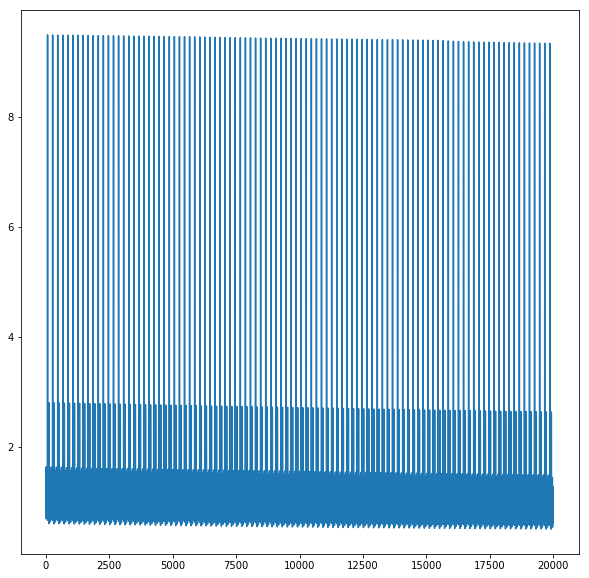

In [19]:
#Pure w/ low learning rate
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.show()

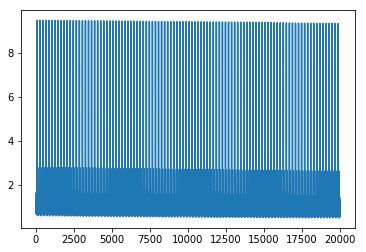

In [20]:
#Pure w/ low learning rate
plt.plot(losses)
plt.show()

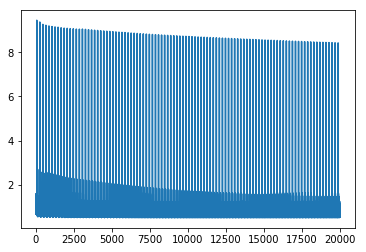

In [18]:
#Pure
plt.plot(losses)
plt.show()

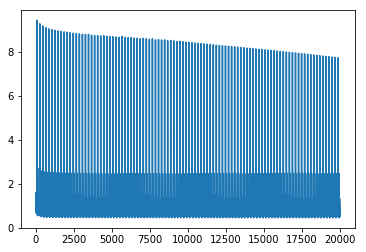

In [18]:
#Sigmoid
plt.plot(losses)
plt.show()

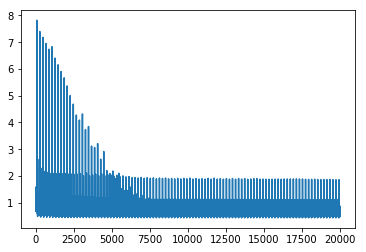

In [30]:
#ReLU
plt.plot(losses)
plt.show()

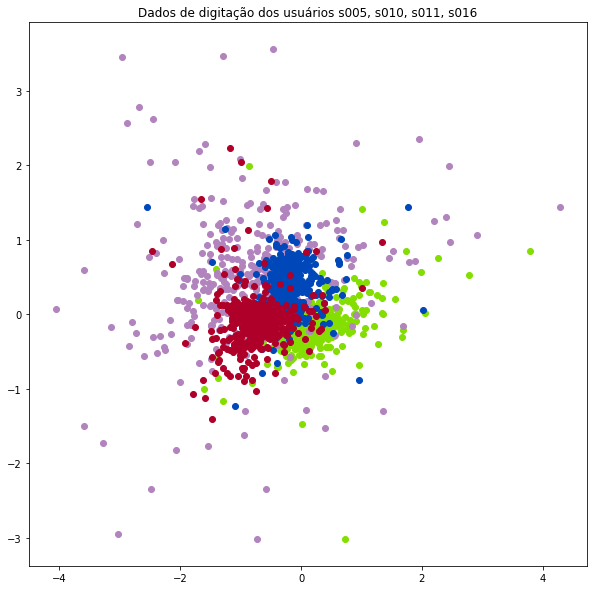

In [21]:
#Pure w/ low learning rate
plot_points_31D = {"s005":[], "s010":[], "s011":[], "s016":[]}
plot_points_2D = {"s005":[], "s010":[], "s011":[], "s016":[]}
for i, point in enumerate(norm_keystrokes):
    if recordings[i][0] in vis_users:
        plot_points_31D[recordings[i][0]].append(point)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for user in plot_points_31D:
        points_31D = np.array(plot_points_31D[user])
        points_2D = sess.run(embedding_2D, feed_dict={x:points_31D})
        plot_points_2D[user] = points_2D

plt.figure(figsize=(10,10))
for user in plot_points_2D:
    plt.scatter(plot_points_2D[user][:,0], plot_points_2D[user][:,1], c=colors[user])
plt.title("Dados de digitação dos usuários {}".format(", ".join(vis_users)))
plt.show()

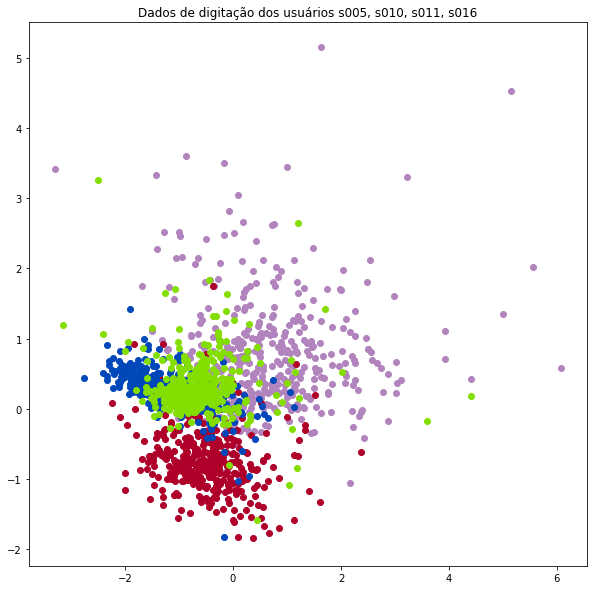

In [19]:
#Pure
plot_points_31D = {"s005":[], "s010":[], "s011":[], "s016":[]}
plot_points_2D = {"s005":[], "s010":[], "s011":[], "s016":[]}
for i, point in enumerate(norm_keystrokes):
    if recordings[i][0] in vis_users:
        plot_points_31D[recordings[i][0]].append(point)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for user in plot_points_31D:
        points_31D = np.array(plot_points_31D[user])
        points_2D = sess.run(embedding_2D, feed_dict={x:points_31D})
        plot_points_2D[user] = points_2D

plt.figure(figsize=(10,10))
for user in plot_points_2D:
    plt.scatter(plot_points_2D[user][:,0], plot_points_2D[user][:,1], c=colors[user])
plt.title("Dados de digitação dos usuários {}".format(", ".join(vis_users)))
plt.show()

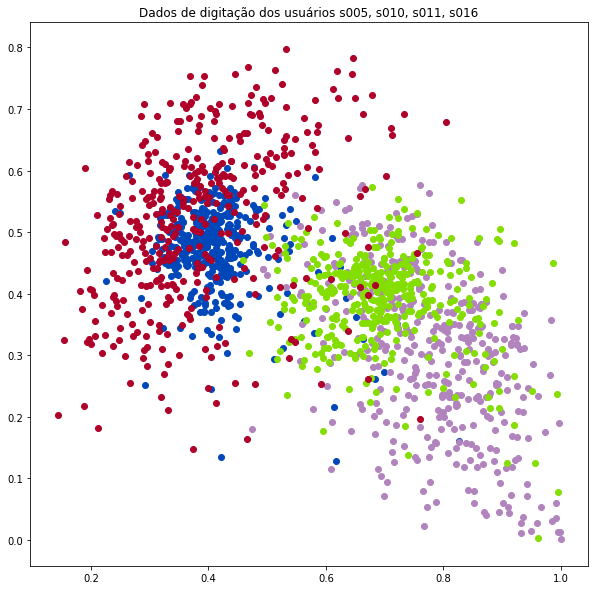

In [19]:
#Sigmoid
plot_points_31D = {"s005":[], "s010":[], "s011":[], "s016":[]}
plot_points_2D = {"s005":[], "s010":[], "s011":[], "s016":[]}
for i, point in enumerate(norm_keystrokes):
    if recordings[i][0] in vis_users:
        plot_points_31D[recordings[i][0]].append(point)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for user in plot_points_31D:
        points_31D = np.array(plot_points_31D[user])
        points_2D = sess.run(embedding_2D, feed_dict={x:points_31D})
        plot_points_2D[user] = points_2D

plt.figure(figsize=(10,10))
for user in plot_points_2D:
    plt.scatter(plot_points_2D[user][:,0], plot_points_2D[user][:,1], c=colors[user])
plt.title("Dados de digitação dos usuários {}".format(", ".join(vis_users)))
plt.show()

## Classificação
Agora que temos um melhor entendimento dos dados do dataset, passemos à parte de classificação de dados.

In [21]:
s = np.std(a, axis=0)
n = (a - m) / s
print(s)
print(n)

[ 1.5  1.5  1.5]
[[-1. -1. -1.]
 [ 1.  1.  1.]]


In [31]:
a = np.diag([1,2,0,0])
b = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
c = a @ b
print(a,"\n\n", b)
print("\n",c)
print(b )

[[1 0 0 0]
 [0 2 0 0]
 [0 0 0 0]
 [0 0 0 0]] 

 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

 [[ 1  2  3  4]
 [10 12 14 16]
 [ 0  0  0  0]
 [ 0  0  0  0]]


In [44]:
t = np.array([[1,0,0,0],[2,0,0,0],[0,1,0,0],[0,2,0,0],[0,1,1,0],[1,0,0,1]])
# t = t.T
d = np.linalg.svd(t)
print(t, end="\n\n")
print(d[0], d[1], d[2], sep="\n\n", end="\n\n")
ss = np.zeros((6,4))
# d[1][2] = 0
# d[1][3] = 0
for i, e in enumerate(d[1]):
    ss[i,i] = e
print(ss)
print("="*50, "\n\n")
print(d[0]@ss@d[2])

[[1 0 0 0]
 [2 0 0 0]
 [0 1 0 0]
 [0 2 0 0]
 [0 1 1 0]
 [1 0 0 1]]

[[  0.00000000e+00  -3.94599292e-01  -2.10455217e-01   0.00000000e+00
    0.00000000e+00  -8.94427191e-01]
 [  0.00000000e+00  -7.89198585e-01  -4.20910435e-01   0.00000000e+00
    0.00000000e+00   4.47213595e-01]
 [ -3.94599292e-01   0.00000000e+00   0.00000000e+00  -2.10455217e-01
   -8.94427191e-01   0.00000000e+00]
 [ -7.89198585e-01   0.00000000e+00   0.00000000e+00  -4.20910435e-01
    4.47213595e-01   0.00000000e+00]
 [ -4.70592172e-01   0.00000000e+00   0.00000000e+00   8.82350841e-01
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -4.70592172e-01   8.82350841e-01   0.00000000e+00
    0.00000000e+00   1.11022302e-16]]

[ 2.48848998  2.48848998  0.89856419  0.89856419]

[[-0.         -0.98195639 -0.18910752  0.        ]
 [-0.98195639  0.         -0.         -0.18910752]
 [-0.18910752  0.          0.          0.98195639]
 [-0.         -0.18910752  0.98195639  0.        ]]

[[ 2.48848998  0.          0.  

In [45]:
partial = keystrokes[:2000]

In [46]:
partial

array([[ 0.1227,  0.3441,  0.2214, ...,  0.2655,  0.1832,  0.1084],
       [ 0.0377,  0.5097,  0.472 , ...,  0.4406,  0.4013,  0.0364],
       [ 0.0853,  0.1757,  0.0904, ...,  0.1929,  0.1121,  0.0829],
       ..., 
       [ 0.0776,  0.3103,  0.2327, ...,  0.2907,  0.1917,  0.0945],
       [ 0.0591,  0.265 ,  0.2059, ...,  0.5553,  0.4746,  0.0886],
       [ 0.0657,  0.409 ,  0.3433, ...,  0.3733,  0.2881,  0.072 ]])

In [47]:
decomp = np.linalg.svd(partial)

In [48]:
U, sigma, Vt = decomp
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(2000, 2000)
(31,)
(31, 31)


[  5.37860351e+01   1.45971181e+01   1.39542872e+01   1.13840973e+01
   9.56374289e+00   9.20264712e+00   7.71927016e+00   7.52113688e+00
   6.41529380e+00   5.77067003e+00   5.50869931e+00   1.58892232e+00
   1.37413431e+00   1.25452098e+00   1.12088379e+00   1.08756954e+00
   9.80826384e-01   8.76163838e-01   8.50212712e-01   8.28806611e-01
   7.73274781e-01   3.51964339e-14   1.44156497e-14   1.19870887e-14
   7.79112368e-15   7.74209255e-15   5.80840869e-15   4.44215664e-15
   4.44215664e-15   3.54364698e-15   2.97049823e-15]


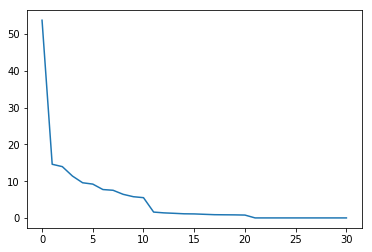

In [49]:
print(sigma)
plt.plot(sigma)
plt.show()

In [50]:
Sigma = np.zeros((2000, 31))
Sigma[0][0] = sigma[0]
Sigma[1][1] = sigma[1]
print(Sigma)

Vt_2D = np.zeros((Vt.shape[0],2))
Vt_2D[:,:2] = Vt[:,:2]
print(Vt_2D)

partial_2D = U.dot(Sigma.dot(Vt_2D))
print(partial_2D)

[[ 53.7860351    0.           0.         ...,   0.           0.           0.        ]
 [  0.          14.59711807   0.         ...,   0.           0.           0.        ]
 [  0.           0.           0.         ...,   0.           0.           0.        ]
 ..., 
 [  0.           0.           0.         ...,   0.           0.           0.        ]
 [  0.           0.           0.         ...,   0.           0.           0.        ]
 [  0.           0.           0.         ...,   0.           0.           0.        ]]
[[ -6.75936637e-02  -2.49557191e-01]
 [ -1.83758381e-02   4.50418569e-01]
 [  1.78634943e-02   1.04421094e-01]
 [ -6.48506372e-02   4.12272012e-01]
 [  1.63725324e-01   2.09097054e-01]
 [ -1.31253972e-01   2.51447174e-02]
 [  7.42528957e-02   8.41307492e-02]
 [ -3.02612331e-02  -1.04679674e-01]
 [  5.76043880e-02   2.65105431e-02]
 [ -6.14543112e-02  -2.18016951e-02]
 [  5.57318797e-02   4.99800247e-02]
 [ -2.57013496e-01  -1.26424121e-01]
 [  3.85613053e-01   1.98459893e

In [55]:
print(Sigma)
pp_2D = U@Sigma[:,:2]
print(pp_2D)
print(pp_2D.shape)

[[ 53.7860351    0.           0.         ...,   0.           0.           0.        ]
 [  0.          14.59711807   0.         ...,   0.           0.           0.        ]
 [  0.           0.           0.         ...,   0.           0.           0.        ]
 ..., 
 [  0.           0.           0.         ...,   0.           0.           0.        ]
 [  0.           0.           0.         ...,   0.           0.           0.        ]
 [  0.           0.           0.         ...,   0.           0.           0.        ]]
[[-1.51415386 -0.19548041]
 [-1.66894887  0.40282269]
 [-0.68747665  0.0050693 ]
 ..., 
 [-1.15396163  0.04060706]
 [-0.96374844  0.27070175]
 [-1.29445221  0.2353598 ]]
(2000, 2)


In [57]:
colors = {
    "s002": "#0048BA",
    "s003": "#B0BF1A",
    "s004": "#7CB9E8",
    "s005": "#C9FFE5",
    "s007": "#B284BE",
    "s008": "#00308F",
    "s010": "#72A0C1",
    "s011": "#AF002A",
    "s012": "#84DE02",
    "s013": "#E32636",
    "s015": "#C46210",
    "s016": "#EFDECD",
    "s017": "#E52B50",
    "s018": "#9F2B68",
    "s019": "#F19CBB",
    "s020": "#AB274F",
    "s021": "#D3212D",
    "s022": "#3B7A57",
    "s024": "#FFBF00",
    "s025": "#FF7E00",
    "s026": "#3B3B6D",
    "s027": "#391802",
    "s028": "#804040",
    "s029": "#D3AF37",
    "s030": "#34B334",
    "s031": "#FF8B00",
    "s032": "#FF9899",
    "s033": "#431C53",
    "s034": "#B32134",
    "s035": "#FF033E",
    "s036": "#CFCFCF",
    "s037": "#551B8C",
    "s038": "#F2B400",
    "s039": "#9966CC",
    "s040": "#A4C639",
    "s041": "#F2F3F4",
    "s042": "#CD9575",
    "s043": "#665D1E",
    "s044": "#915C83",
    "s046": "#841B2D",
    "s047": "#FAEBD7",
    "s048": "#008000",
    "s049": "#66B447",
    "s050": "#8DB600",
    "s051": "#FBCEB1",
    "s052": "#00FFFF",
    "s053": "#7FFFD4",
    "s054": "#D0FF14",
    "s055": "#C0C0C0",
    "s056": "#4B5320",
    "s057": "#3B444B"
}

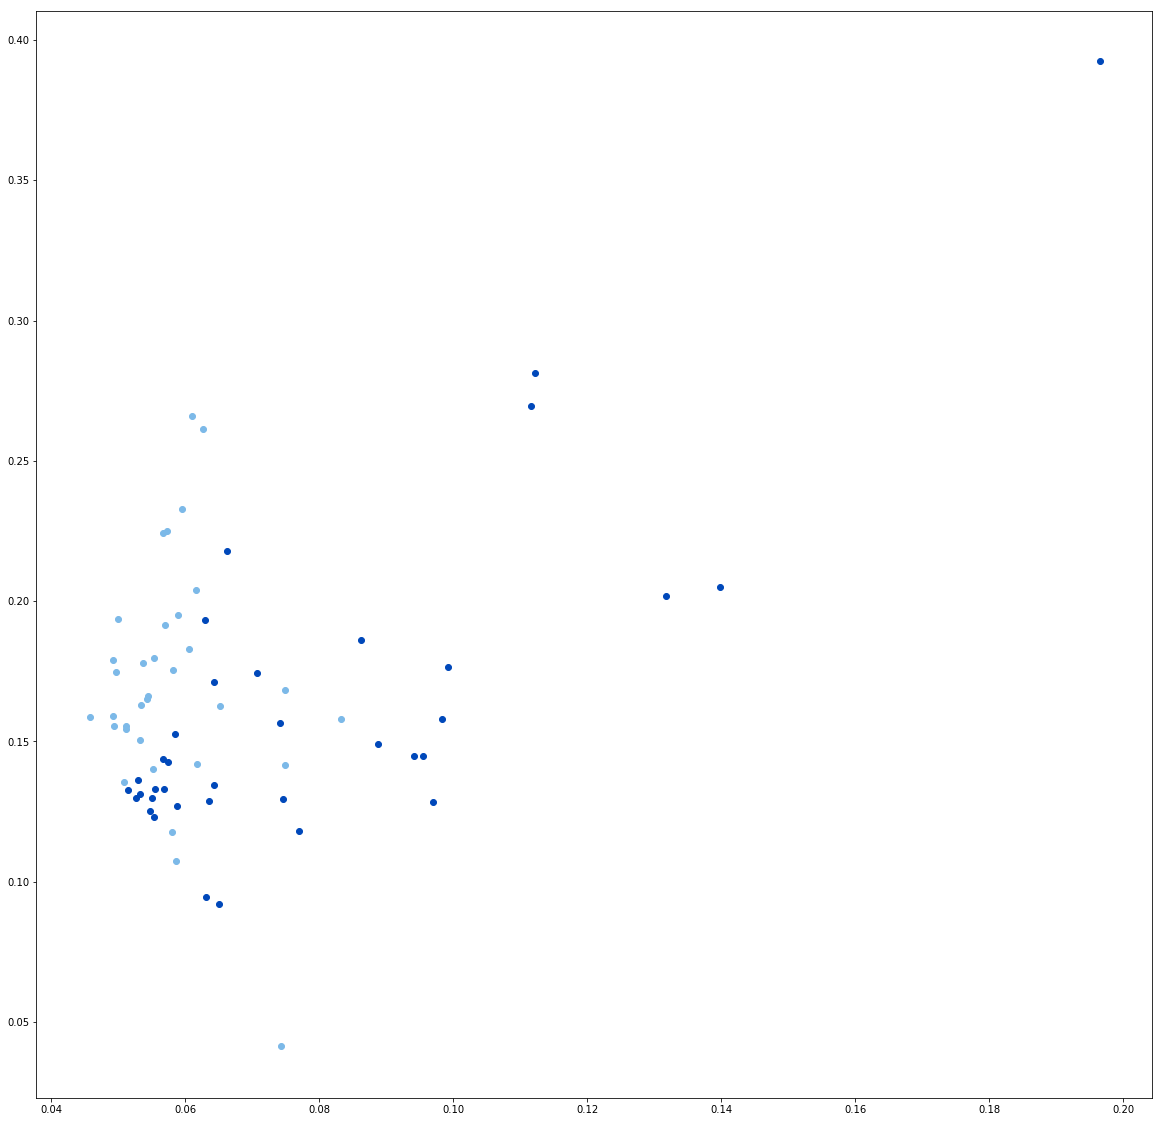

In [61]:
plt.figure(figsize=(20,20))
for i, point in enumerate(partial_2D):
    if recordings[i][0] == "s002" or recordings[i][0] == "s004":
        plt.scatter(point[0], point[1], c=colors[recordings[i][0]])
plt.show()

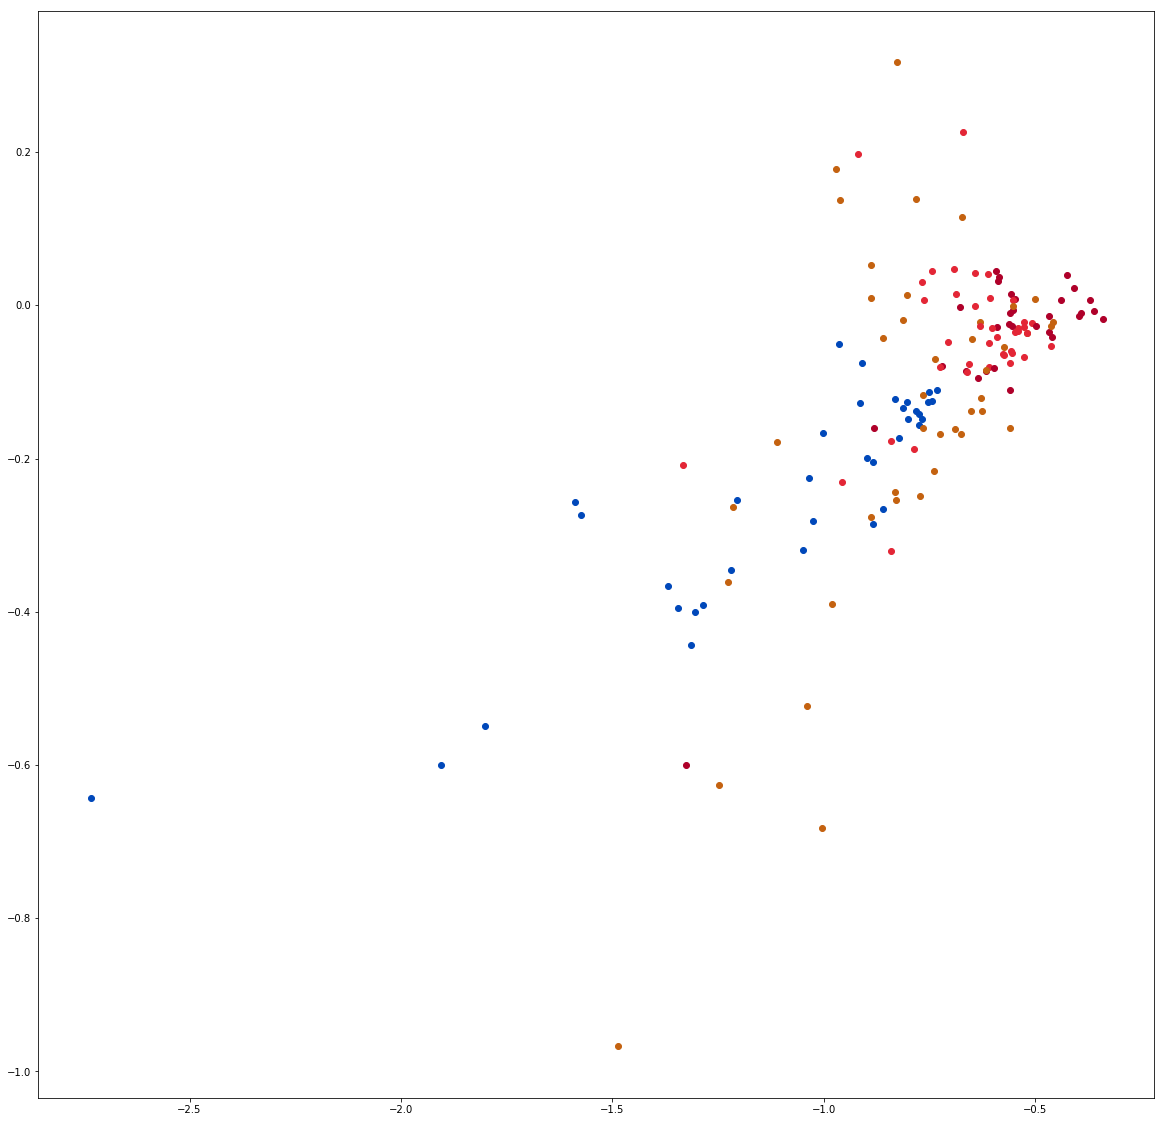

In [74]:
plt.figure(figsize=(20,20))
for i, point in enumerate(pp_2D):
    if recordings[i][0] == "s002" or recordings[i][0] == "s013" or recordings[i][0] == "s011" or recordings[i][0] == "s015":
        plt.scatter(point[0], point[1], c=colors[recordings[i][0]])
plt.show()

In [13]:
partial_2D

array([[ 0.10593932,  0.28981998],
       [ 0.10540816,  0.59793701],
       [ 0.04637591,  0.17384805],
       ..., 
       [ 0.07725431,  0.3062696 ],
       [ 0.06016892,  0.36243945],
       [ 0.08317183,  0.42905028]])